# Read YYYYMMDD.pkl files, add water level columns, and save as YYYYMMDD_final.pkl files
SCAFFOLD: I still need to align Steve's measurement times with UTC-4 hours
## 1. Setup environment

In [ ]:
import os
import header
paths = header.setup_environment()
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#print(paths)
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/O5_DAILY_PSI'
else:
    INPUTDIR = os.path.join(paths['DROPBOX_DATA_TOP'], 'WellData', '05_DAILY_PSI')
OUTPUTDIR = INPUTDIR.replace('05_DAILY_PSI', '07_DAILY_WLM')
if not os.path.isdir(OUTPUTDIR):
    os.makedirs(OUTPUTDIR)
#print(os.listdir(INPUTDIR))
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
serials = LLE.watercolumns
sensors = {'shallow':[serials[i] for i in [0,1,4]], 'intermediate':[serials[i] for i in [2,3,5]]}
print(sensors)

## 2. Read Steve's water levels Excel data (reformatted by me), create a datetime column, and plot

In [ ]:
wells = ['shallow', 'intermediate']
measuredWaterLevelsDF = {}
fh, axs = plt.subplots(1,1)
for well in wells:
    measuredWaterLevelsDF[well] = pd.read_excel('/home/thompsong/Dropbox/waterlevels.xlsx', sheet_name=well)
    measuredWaterLevelsDF[well].columns = measuredWaterLevelsDF[well].columns.str.replace(' ', '')
    #display(measuredWaterLevelsDF[well])
    measuredWaterLevelsDF[well]['datetime']  = pd.to_datetime( measuredWaterLevelsDF[well]['Date'].astype(str)+' '+measuredWaterLevelsDF[well]['Time'].astype(str))
    display(measuredWaterLevelsDF[well])
    measuredWaterLevelsDF[well].rename(columns={'CorrectedElevationinFeet(NAVD)':'NAVD88_Feet'}, inplace=True)
    measuredWaterLevelsDF[well].plot(ax=axs, x='datetime', y='NAVD88_Feet', label=well, style='o', ylabel='Water Level (NAV88D, Feet)')

## 3. Read YYYYMMDD.pkl for days where we have Steve's water level measurements, plot them, and compute differences
loop over dates, read the daily pickle files YYYYMMDD.pkl which are in PSI and depth corrected - and estimate water level above NAVD88 in meters
- despike the data for each well/sensor, 
- convert it to feet of water, 
- convert estimated water level from feet to meters
- save the corrected data to YYYYMMDD_wlm.pkl, with new columns like serialno_wlm
we downsample the data for plotting
for each of Steve's water level measurements, we compare with the estimated values, and save this as a DataFrame/CSV file

In [ ]:
# get list of unique dates for which Steve made measurements
dates = measuredWaterLevelsDF['shallow']['Date'].unique()
#print(dates)

lod = []
for d in dates:

    try:
        pklfile = os.path.join(INPUTDIR, f'{d.strftime("%Y%m%d")}.pkl')
        daydf = pd.read_pickle(pklfile)
        
    except:
        print(f'Pickle file {pklfile} for {d} does not exist, trying previous day') # for 2022-12-03, and 2022-12-02 is bad
        if d==pd.to_datetime('2022-12-03'):
            filed = d - pd.Timedelta(hours=48)
            pklfile = os.path.join(INPUTDIR, f'{filed.strftime("%Y%m%d")}.pkl')
            daydf = pd.read_pickle(pklfile)
        else:
            continue

    # drop Temperature columns
    #daydf.drop(columns=daydf.columns[daydf.columns.str.startswith('Therm')], inplace=True)
    #display(daydf)

    # Loop over sensors in each well. Create two new columns like 1224621_corrected, and 1226421_wl
    for well in wells:
        for serial in sensors[well]:
            col = f'{serial}_corrected'
            newcol = f'{serial}_wlm'
            print('\ndespiking', d, well, col)
            wlmseries = LLE.median_despike(daydf[col], 30*100*60, threshold=1/12) # 30 minutes of data. 1 inch max departure from median in that time.
            daydf[newcol] = LLE.psi2meters(wlmseries)

    # Save the dataframe with these two new columns per sensor - not really needed, since we will loop over all dates later, not just measurement dates
    #pkloutfile = os.path.join(INPUTDIR, f'{d.strftime("%Y%m%d")}_feet.pkl')
    #daydf.to_pickle(pkloutfile)
    
    # downsample to 1-minute for plotting purposes
    daydf.set_index('datetime', inplace=True)
    daydf = daydf.resample('1min').median()
    daydf.reset_index(inplace=True)

    # plot estimated and measured water levels & compute difference between them
    fh, axs = plt.subplots(2,1)
    for i, well in enumerate(wells):
        #print('*******************')
        #print(f'**** {well} Well ****')
        wlm_cols = [serialno + '_wlm' for serialno in sensors[well]]
        daydf.plot(ax=axs[i], x='datetime', y=wlm_cols) # plot estimated water levels

        # filter Steve's measurements for this day, plot for each well
        truedf = measuredWaterLevelsDF[well]
        mindt = min( [d,daydf['datetime'].min()] )
        trueday = truedf[(truedf['datetime']>mindt) & (truedf['datetime']<d+pd.Timedelta(hours=24))]
        trueday['wlm'] = LLE.feet2meters(trueday['NAVD88_Feet'])
        trueday.plot(ax=axs[i], x='datetime',y='wlm', style='o', label='measured', ylabel='Water Level (m, NAVD88)', xlim=[mindt,d+pd.Timedelta(hours=24)], title=well)

        # difference between estimated and measured times 
        for j, row in trueday.iterrows():
            #print(f'Measured {row["NAVD88_Feet"]} at {row["datetime"]}')
            for serial in wlm_cols: #sensors[well]:
                serialdf = daydf.copy().dropna(subset=[serial])
                serialdf['timediff'] = abs(serialdf['datetime']-row['datetime'])
                timediff = serialdf['timediff'].min()
                idx = serialdf['timediff'].idxmin()
                datadf = serialdf.loc[idx]
                #print(f'- Estimated {datadf[serial]:.3f} feet at {datadf["datetime"]} from sensor {serial}: time diff={timediff}')
                
                # here we effectively are adding a new row to the waterleveldf dataframe
                lod.append({'well':well, 'serial':serial, 'measured_datetime':row['datetime'], 'measured_wlm':row['wlm'], \
                            'estimated_datetime':datadf['datetime'], 'estimated_wlm':datadf[serial], 'datetime_diff':timediff, 'wlm_diff':row['wlm']-datadf[serial]})

    plt.show()
    waterleveldf = pd.DataFrame(lod)
    
display(waterleveldf)

# save waterlevel dataframe, which captures differences in estimated and measured water levels
waterleveldf.to_csv(os.path.join(OUTPUTDIR, 'waterleveldf.csv'))


# 4. estimate water level height corrections needed to best fit estimated water levels with measured levels
* plot of water level difference between measured and estimated for each sensor. 
* create a 1-minute sampled timeseries of the difference, using linear interpolation
* save this as a height_correction.csv file for each sensor

In [ ]:
heightshiftdfs = {}
for well in wells:
    fig, axs = plt.subplots(len(sensors[well]),1)
    dfwell = waterleveldf[waterleveldf['well']==well]
    
    for i,serial in enumerate(sensors[well]):
        dfsensor = dfwell[dfwell['serial']==serial]
        dfsensor.plot(ax=axs[i], x='estimated_datetime', y='wlm_diff', ylabel='meters', legend=False, title=f'Water Level Difference (M-E) for sensor {serial}', style='o-', grid=True)
        print('interpolating water level correction for ',serial)

        # resample measured data from intermittent sparse to 1-minute
        thisdf = dfsensor[['measured_datetime', 'wlm_diff']]
        thisdf.set_index('measured_datetime', inplace=True)
        thisdf = thisdf.resample('1min').interpolate()
        thisdf.reset_index(inplace=True)
        heightshiftdfs[serial] = thisdf
        thisdf.plot(ax=axs[i], x='measured_datetime',y='wlm_diff', label='interp')
        hcfile = os.path.join(OUTPUTDIR, f'{serial}_height_correction_meters.csv')
        print(f'Saving {hcfile}')
        thisdf.to_csv(hcfile, index=False)

grouped=waterleveldf.groupby(['serial'])
for name,group in grouped:
    print(f'Water level estimated for {name} is on average too low compared to measured value by {group["wlm_diff"].mean():.3f} meters')


# 5. Process all days
* loop over all days. we will:
* - choose an output filename YYYYMMDD_final.pkl
* - choose an output plot YYYYMMDD_final.png
* - load the YYYYMMDD.pkl file if neither of the above exist
* - drop any Thermal columns
* - loop over wells
*   - loop over sensors
*   - despike the data
*   - convert water level in meters
*   - load height correction data from last step - which corrects estimates to measured data at certain times
*  - resample height correction data from 60-s to 100 Hz
*   - creates a column of the height correction labelled {serial}_wlmcorr
* - saves the data to YYYYMMDD.pkl in output directory (different from input)
* - creates a dayplot YYYYMMDD.png

Must do the height correction first!


despiking 2022-07-21 00:00:00 shallow 1226419

correcting 2022-07-21 00:00:00 shallow 1226419

despiking 2022-07-21 00:00:00 shallow 1226421

correcting 2022-07-21 00:00:00 shallow 1226421

despiking 2022-07-21 00:00:00 shallow 1226423

correcting 2022-07-21 00:00:00 shallow 1226423

despiking 2022-07-21 00:00:00 intermediate 2151691

correcting 2022-07-21 00:00:00 intermediate 2151691

despiking 2022-07-21 00:00:00 intermediate 2149882

correcting 2022-07-21 00:00:00 intermediate 2149882

despiking 2022-07-21 00:00:00 intermediate 2151692

correcting 2022-07-21 00:00:00 intermediate 2151692
*******************
**** shallow Well ****
*******************
**** intermediate Well ****

despiking 2022-07-22 00:00:00 shallow 1226419

correcting 2022-07-22 00:00:00 shallow 1226419

despiking 2022-07-22 00:00:00 shallow 1226421

correcting 2022-07-22 00:00:00 shallow 1226421

despiking 2022-07-22 00:00:00 shallow 1226423

correcting 2022-07-22 00:00:00 shallow 1226423

despiking 2022-07-22 00

/tmp/ipykernel_1503767/3634828377.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fh, axs = plt.subplots(2,1)


*******************
**** shallow Well ****
*******************
**** intermediate Well ****

despiking 2022-08-11 00:00:00 shallow 1226423

correcting 2022-08-11 00:00:00 shallow 1226423

despiking 2022-08-11 00:00:00 intermediate 2151692

correcting 2022-08-11 00:00:00 intermediate 2151692
*******************
**** shallow Well ****
*******************
**** intermediate Well ****

despiking 2022-08-12 00:00:00 shallow 1226423

correcting 2022-08-12 00:00:00 shallow 1226423

despiking 2022-08-12 00:00:00 intermediate 2151692

correcting 2022-08-12 00:00:00 intermediate 2151692
*******************
**** shallow Well ****
*******************
**** intermediate Well ****

despiking 2022-08-13 00:00:00 shallow 1226423

correcting 2022-08-13 00:00:00 shallow 1226423

despiking 2022-08-13 00:00:00 intermediate 2151692

correcting 2022-08-13 00:00:00 intermediate 2151692
*******************
**** shallow Well ****
*******************
**** intermediate Well ****

despiking 2022-08-14 00:00:00 shall

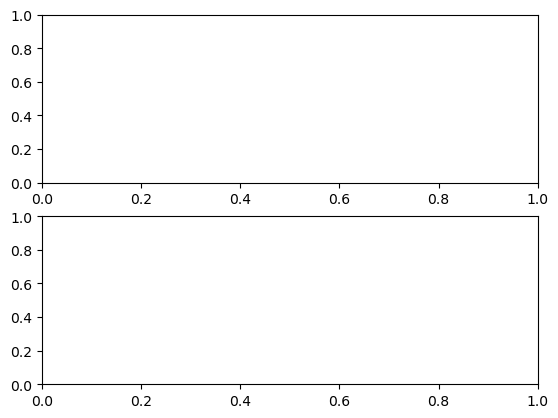

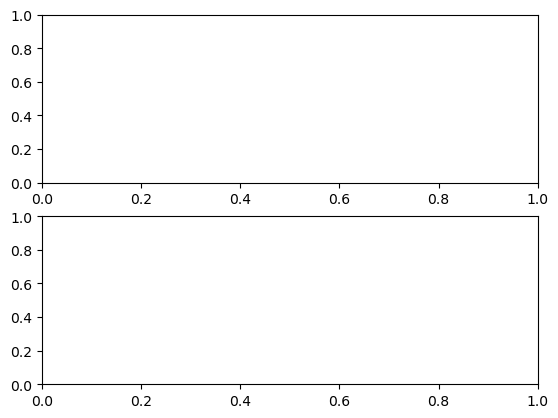

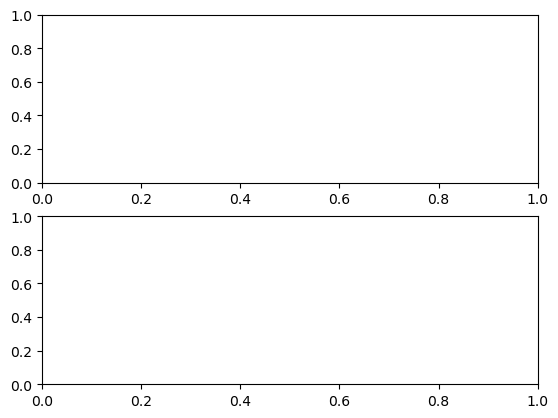

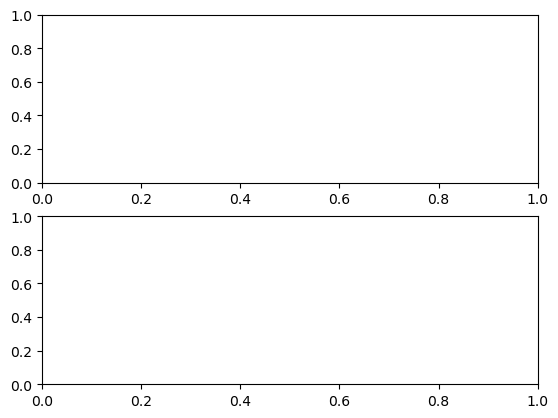

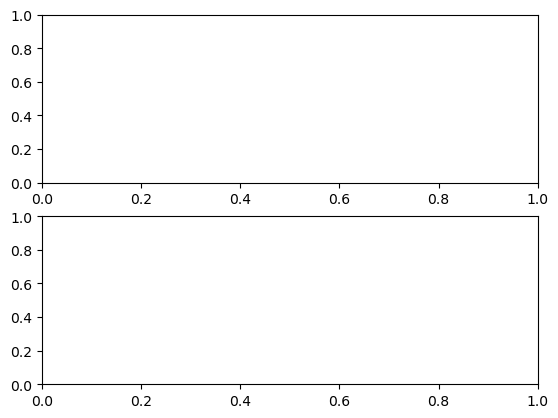

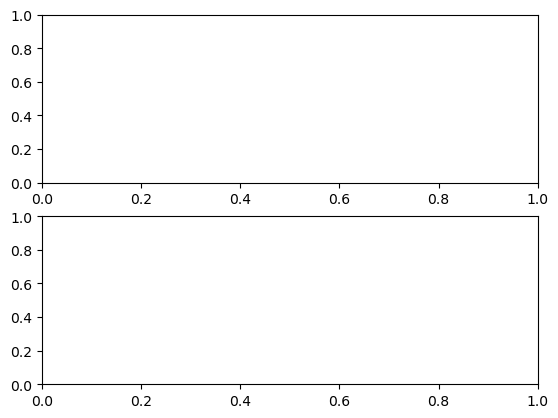

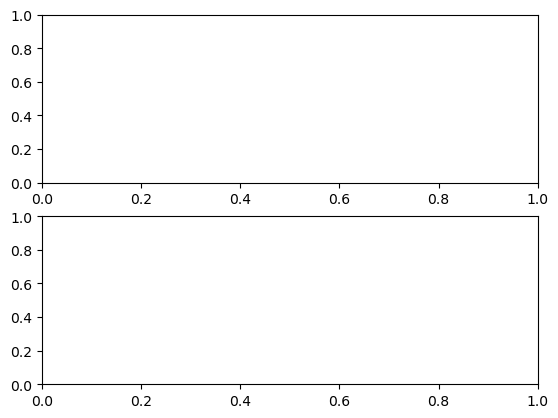

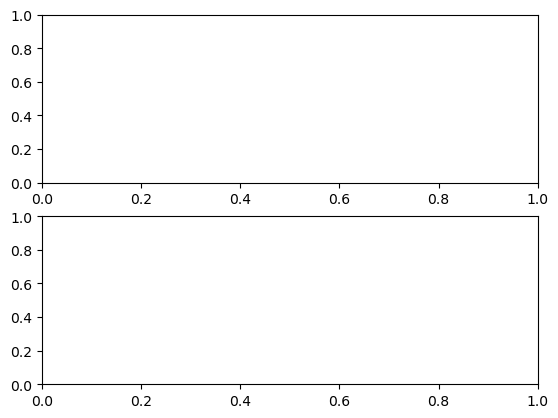

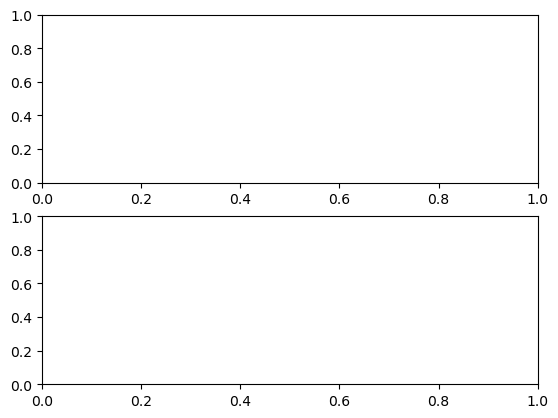

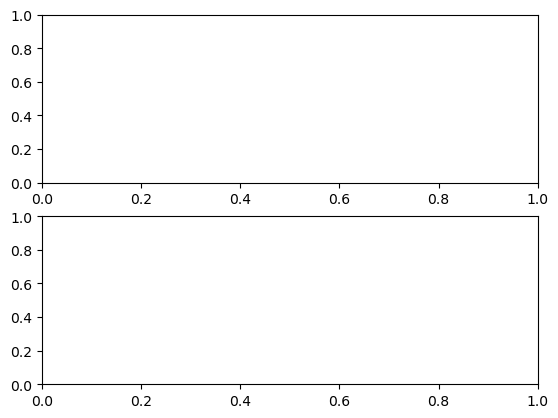

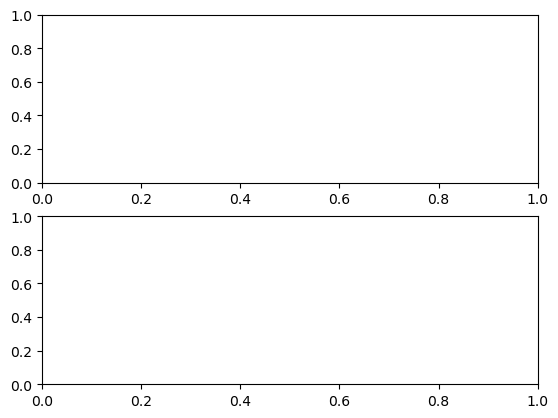

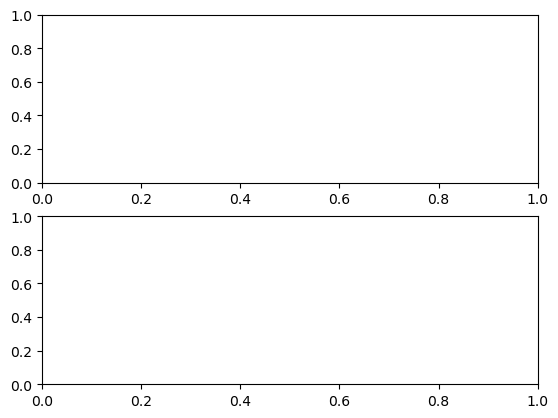

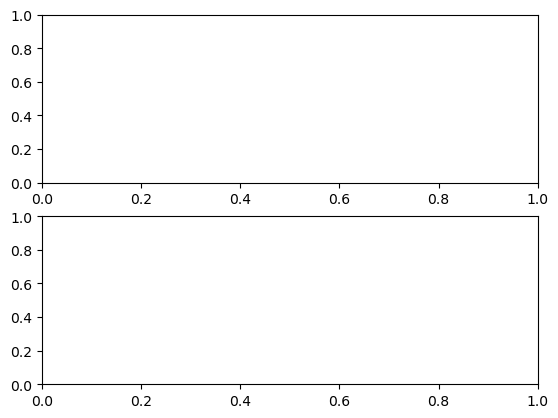

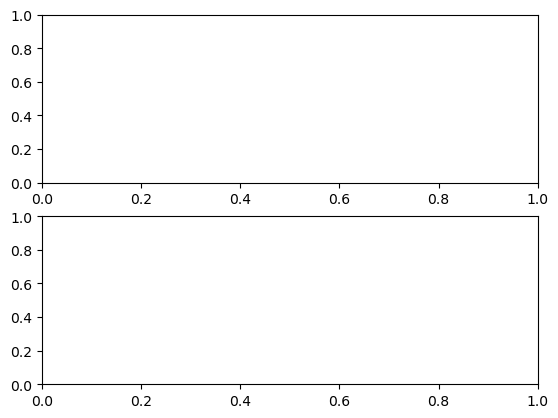

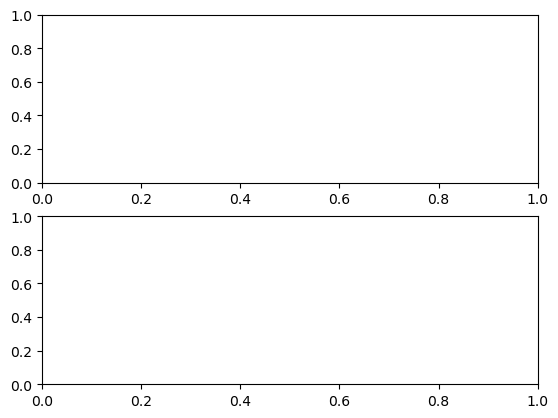

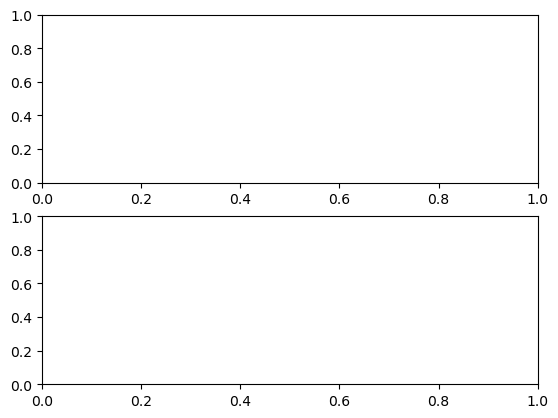

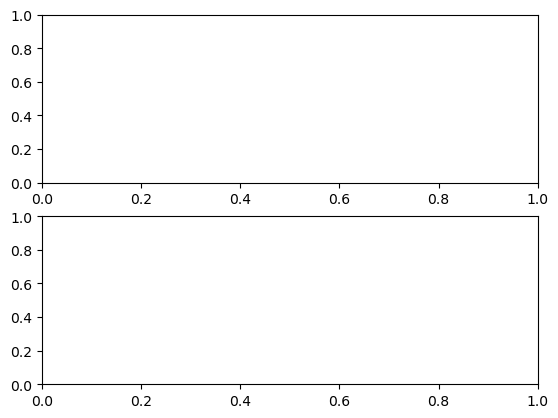

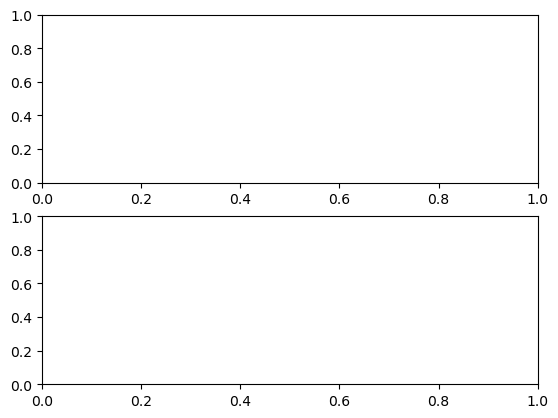

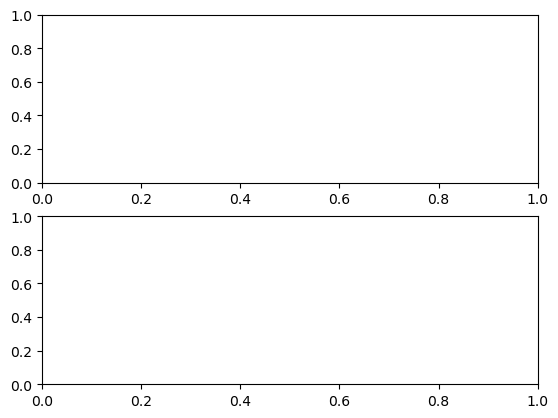

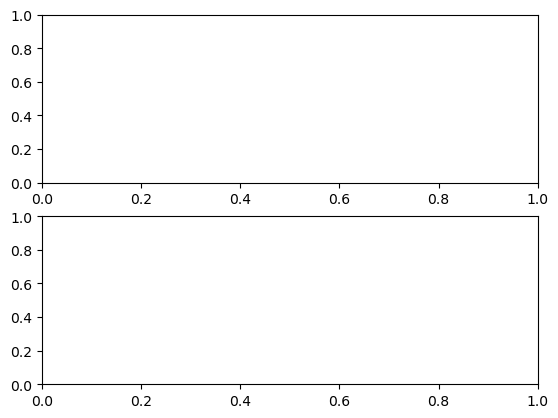

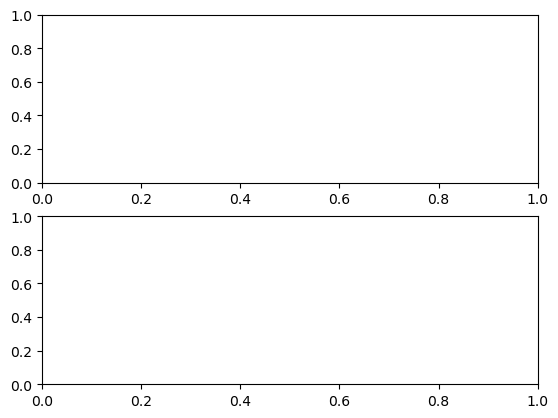

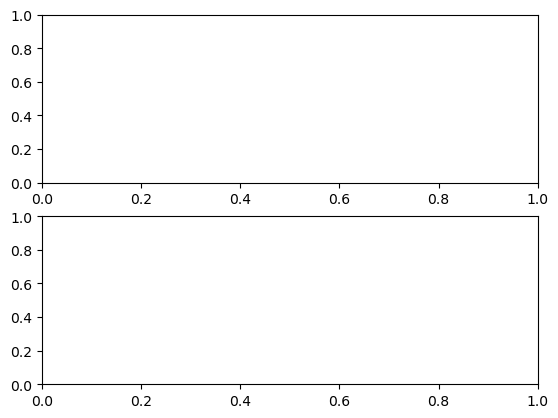

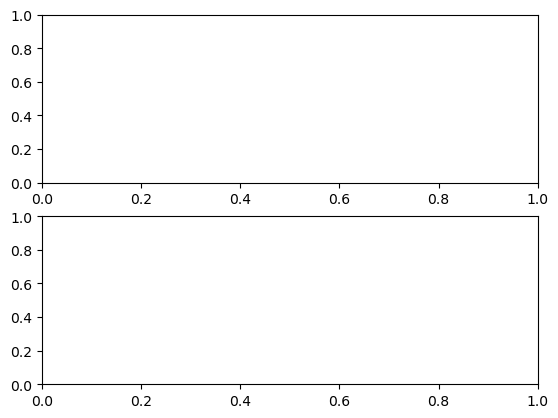

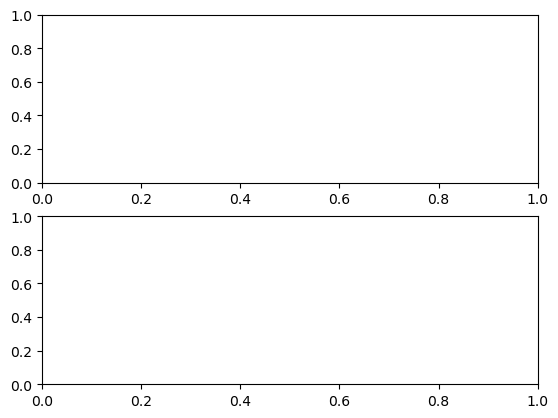

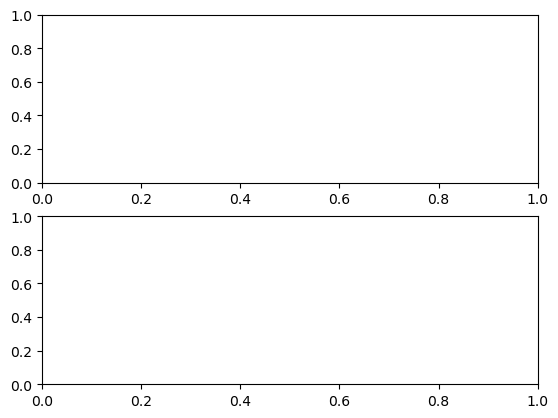

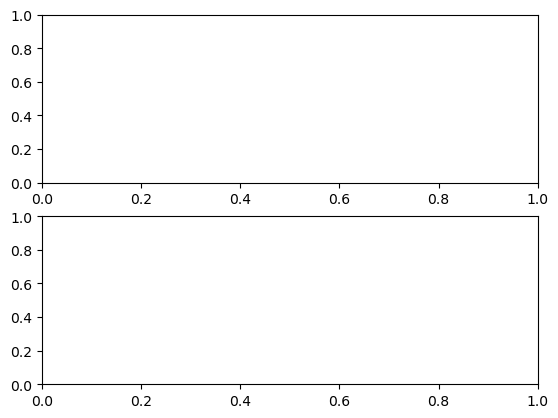

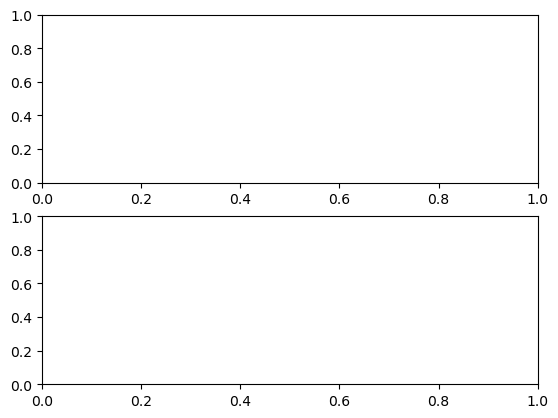

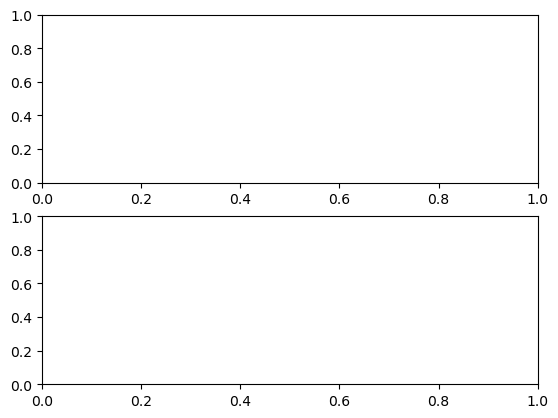

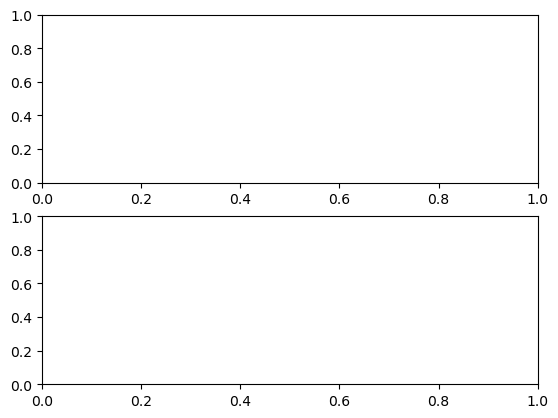

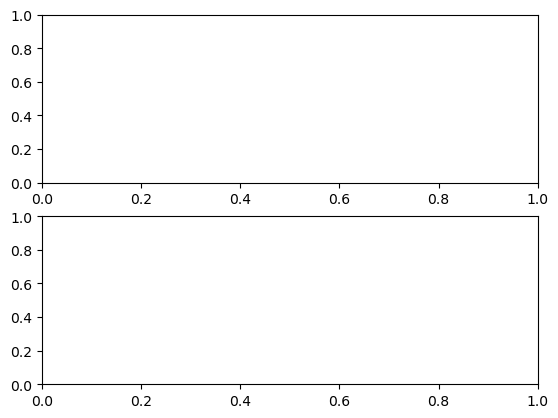

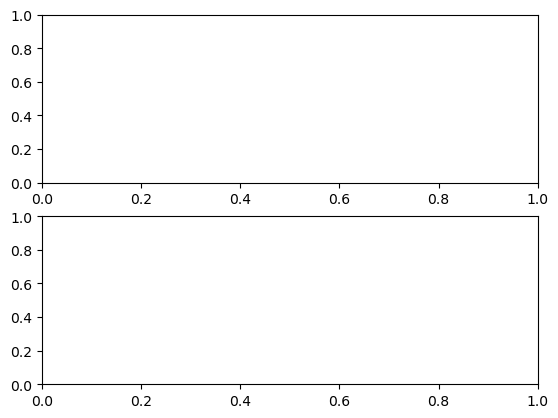

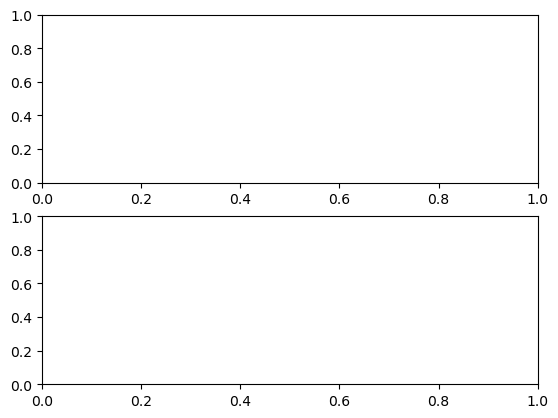

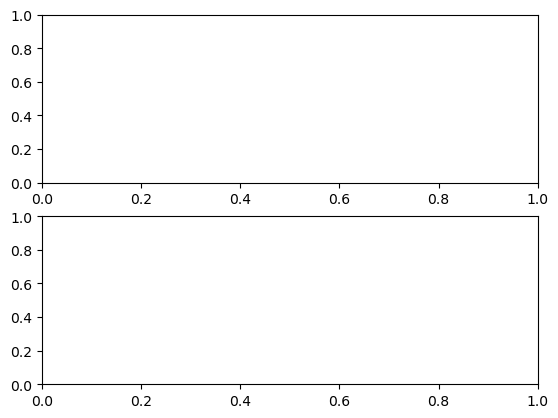

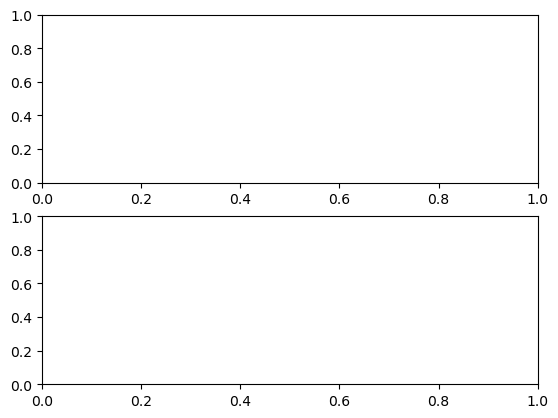

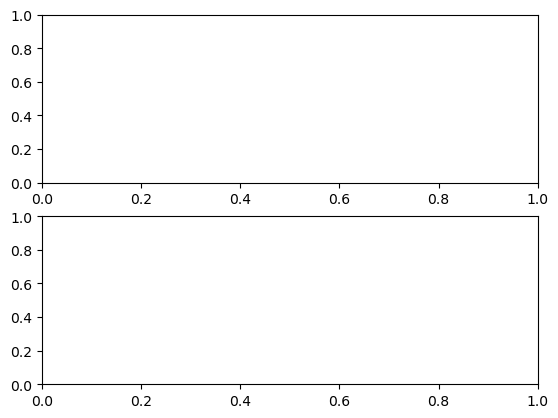

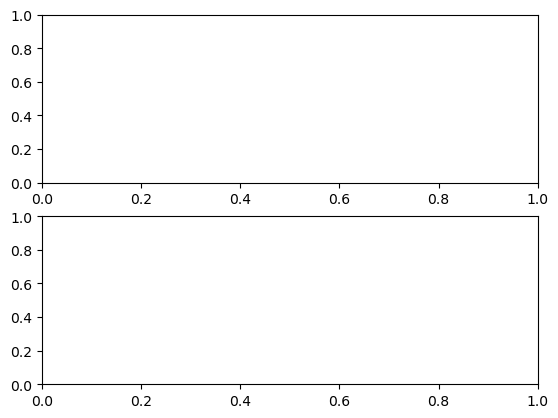

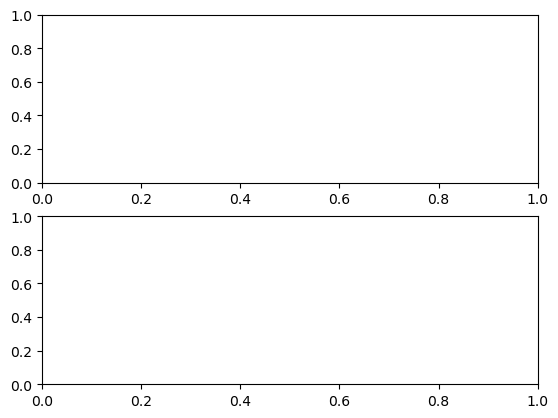

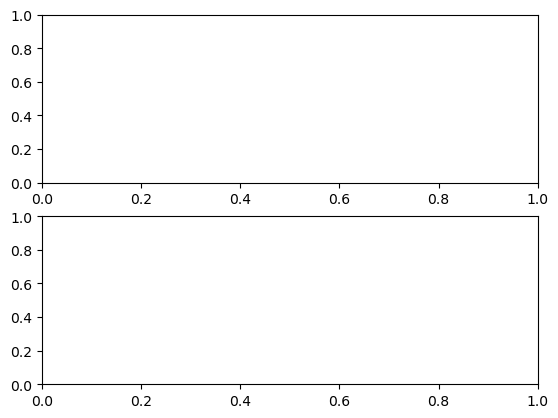

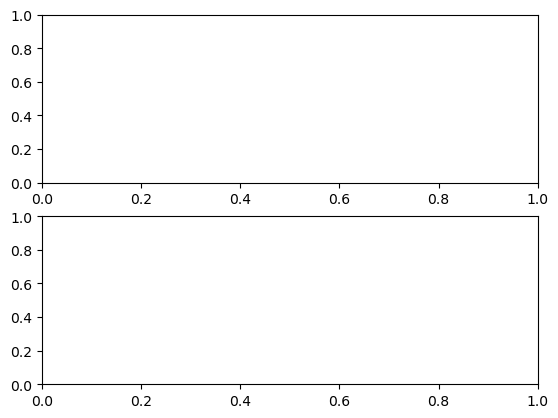

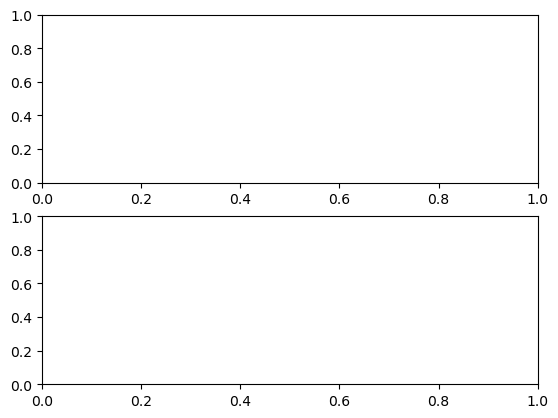

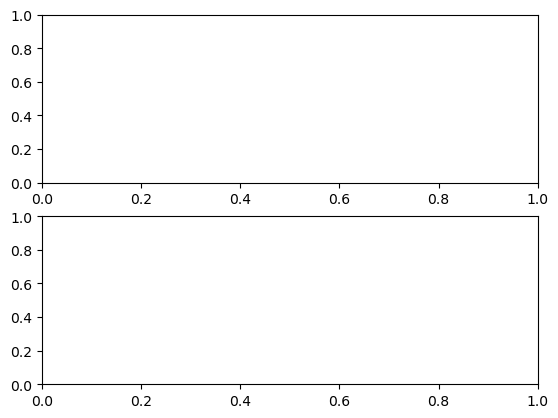

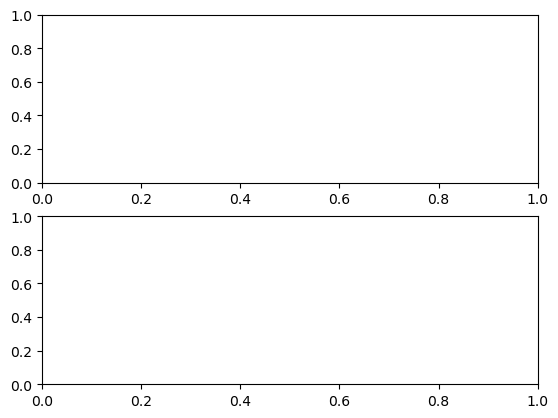

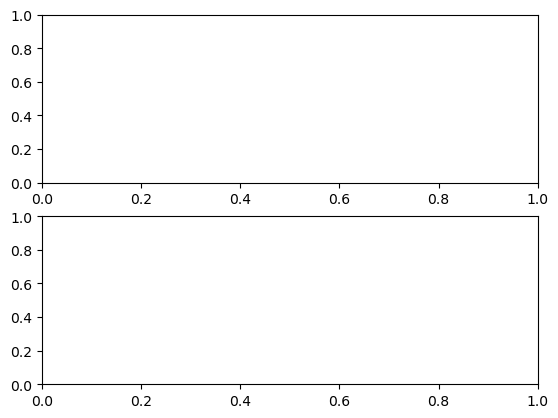

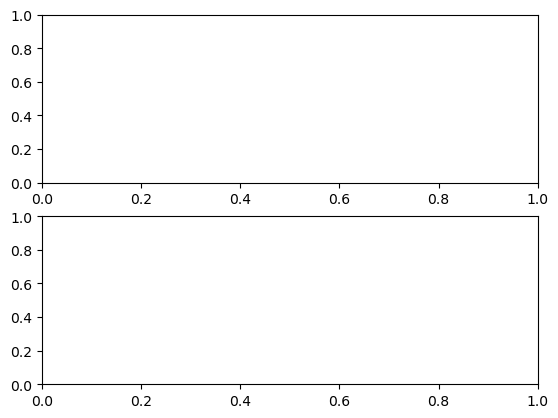

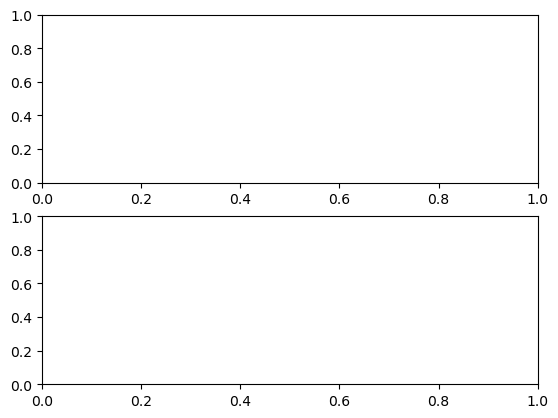

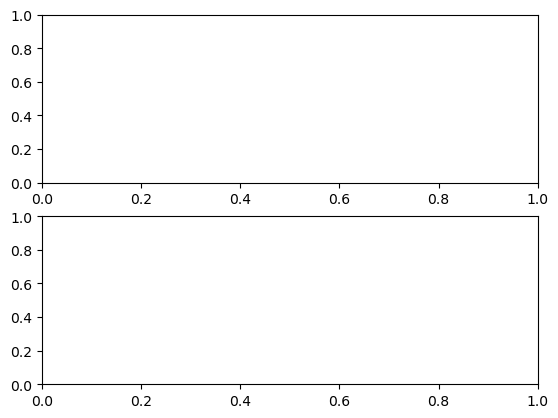

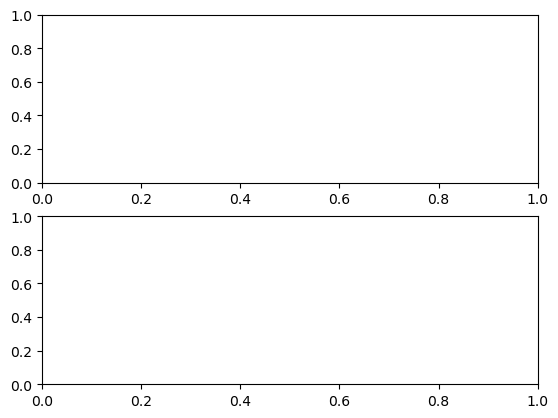

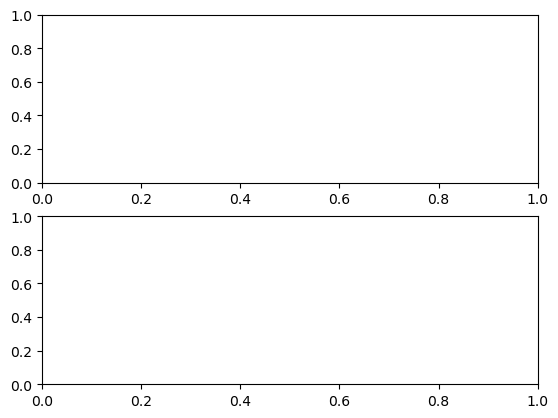

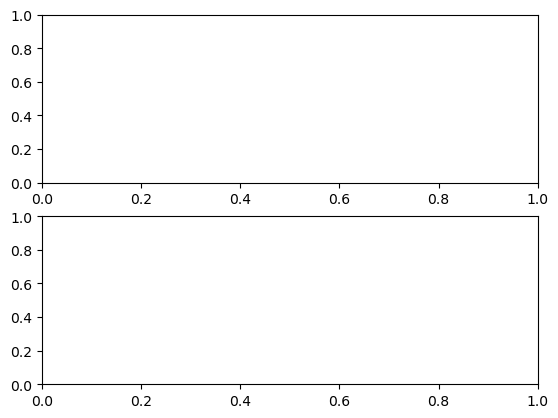

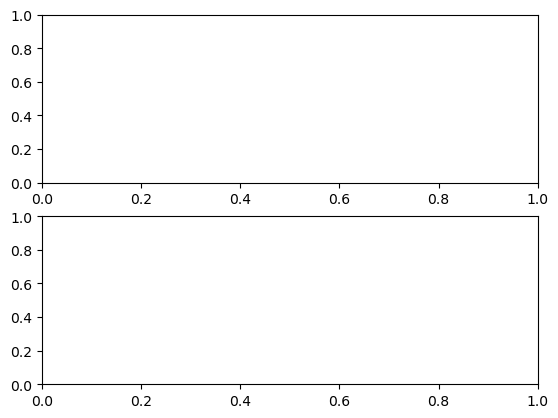

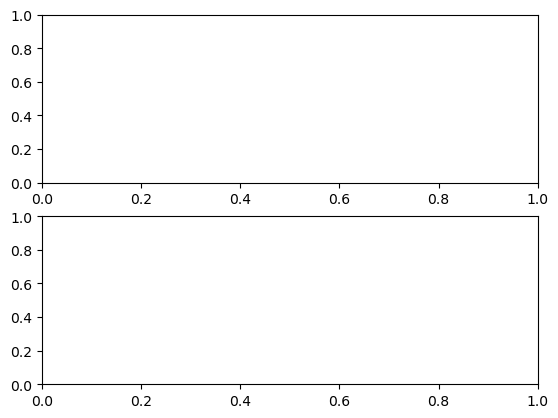

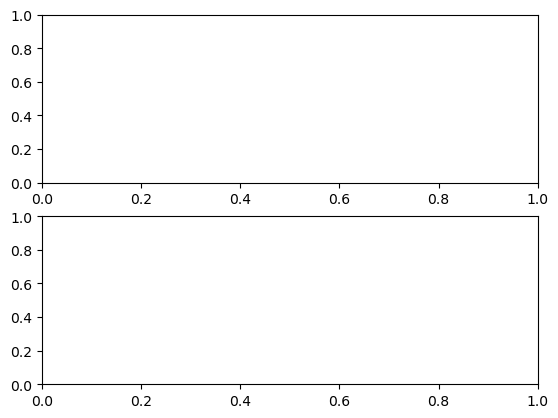

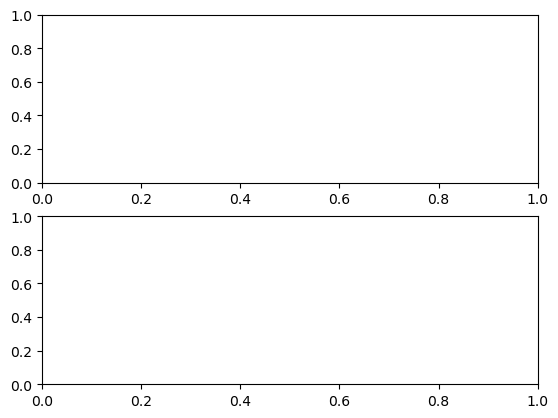

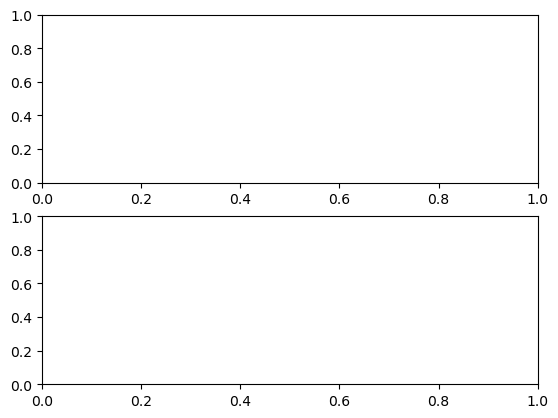

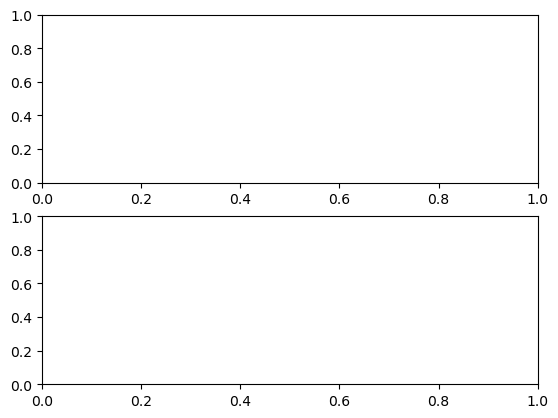

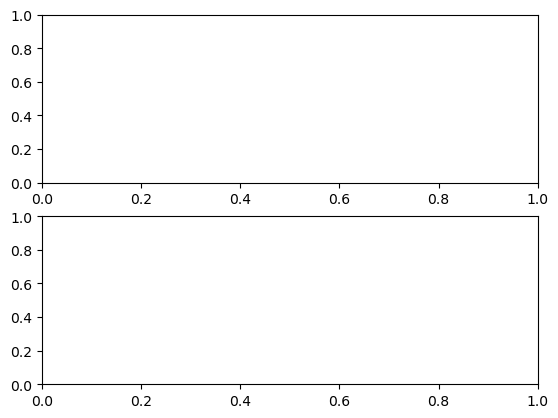

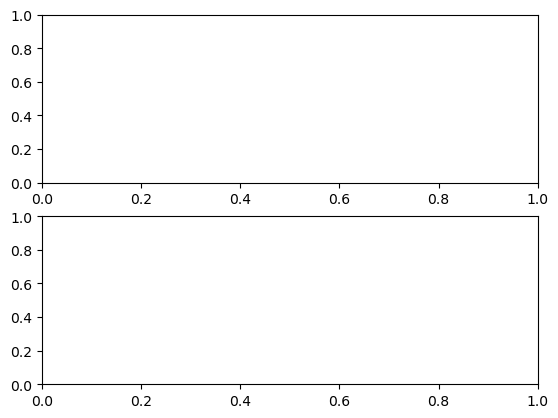

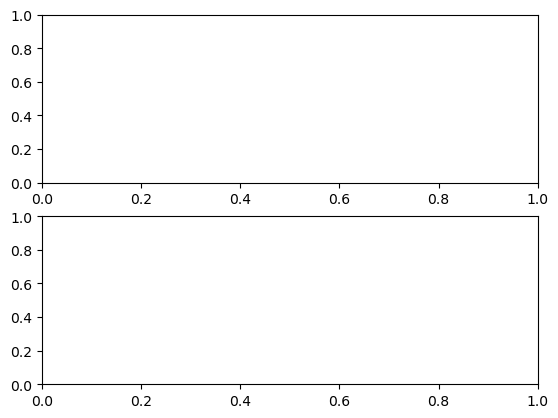

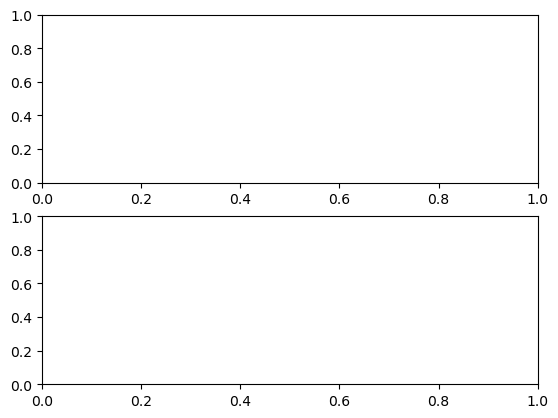

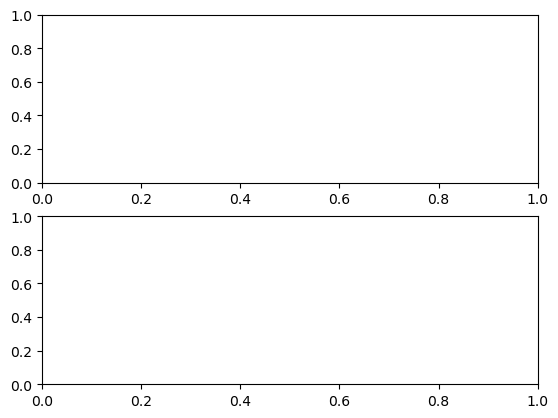

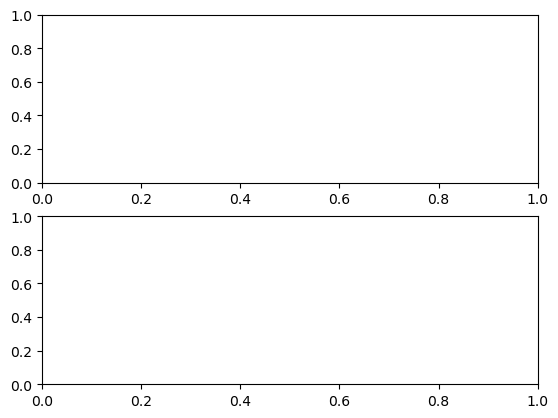

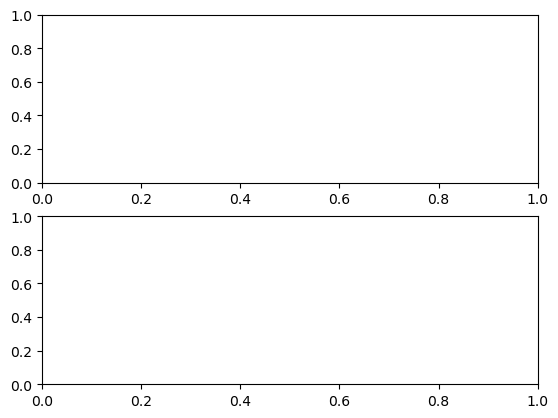

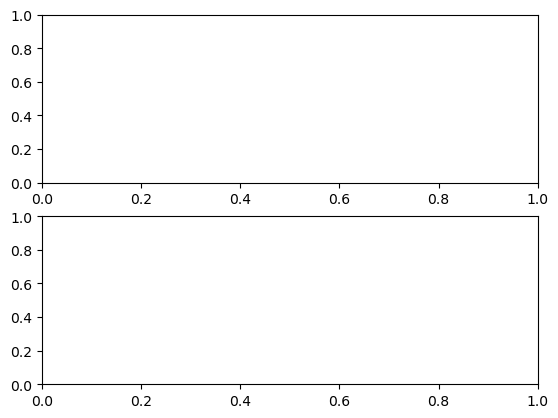

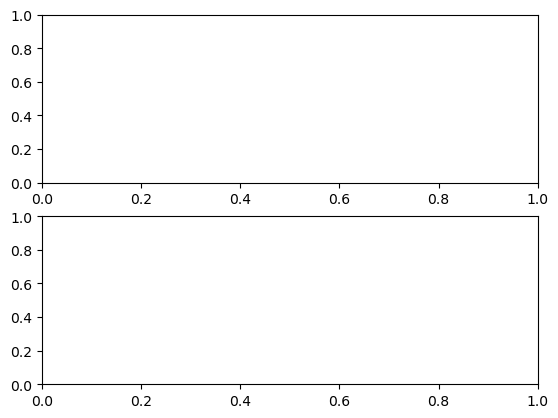

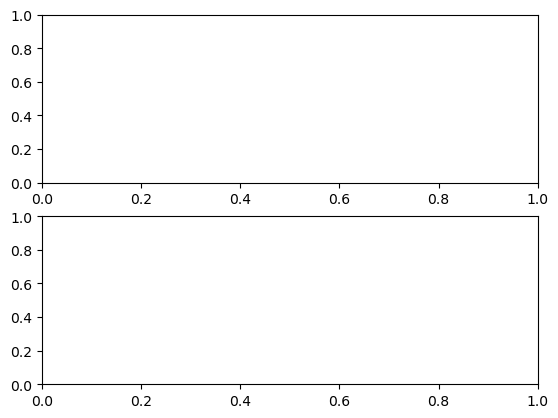

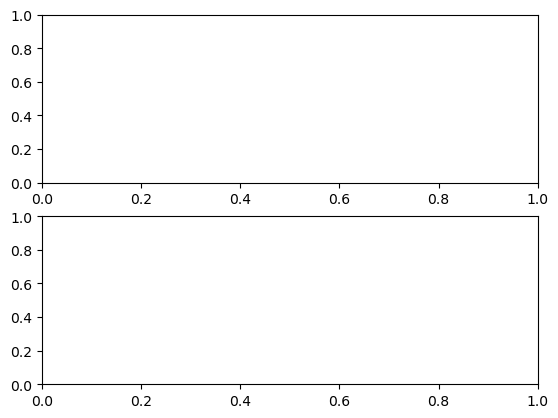

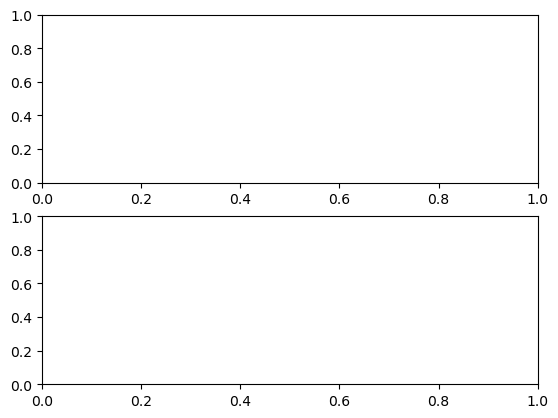

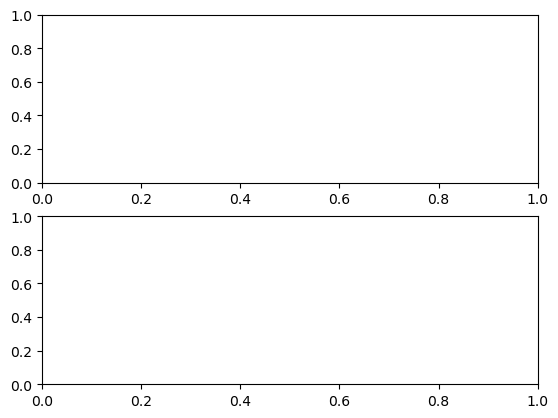

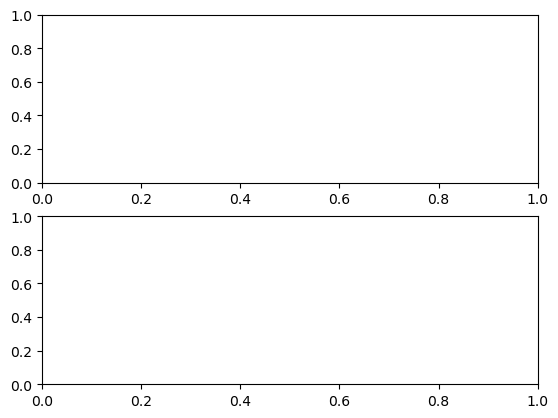

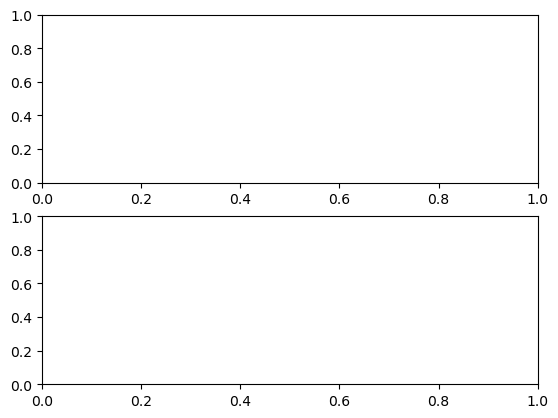

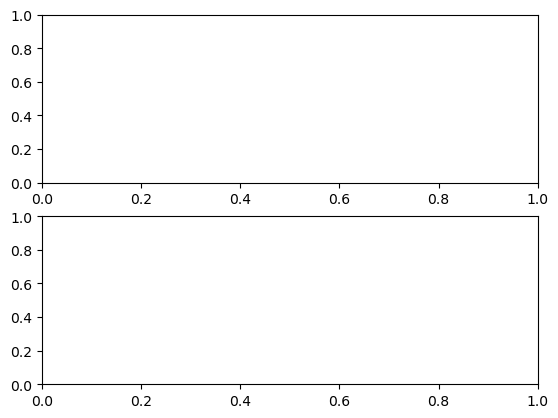

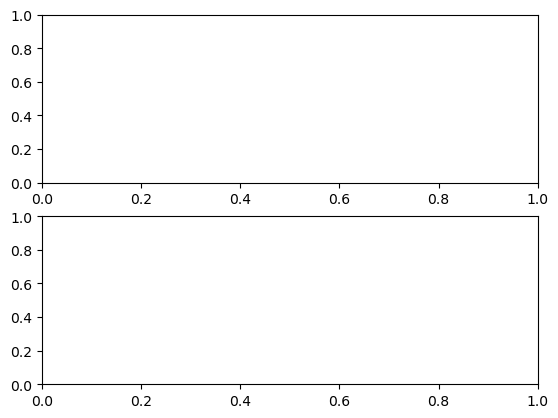

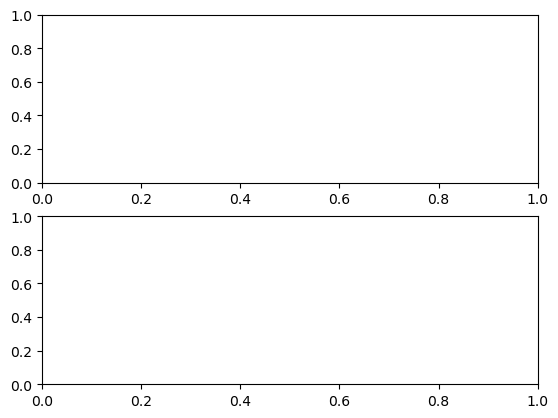

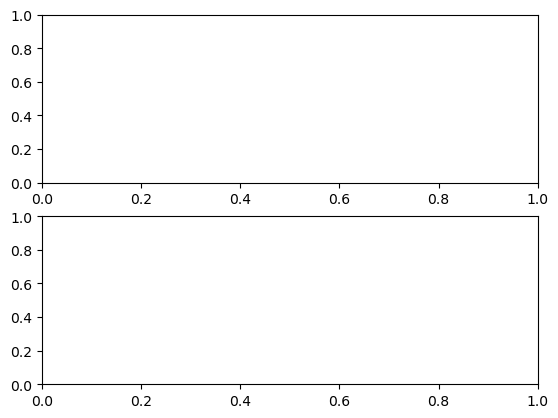

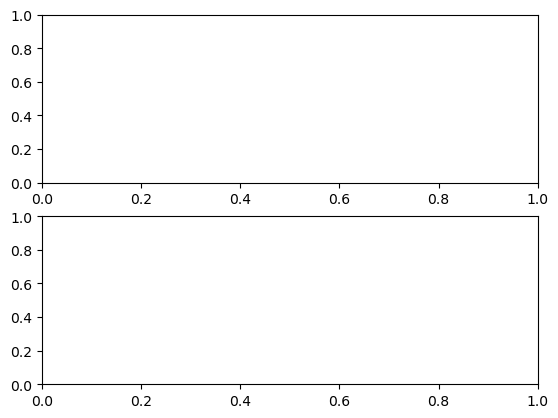

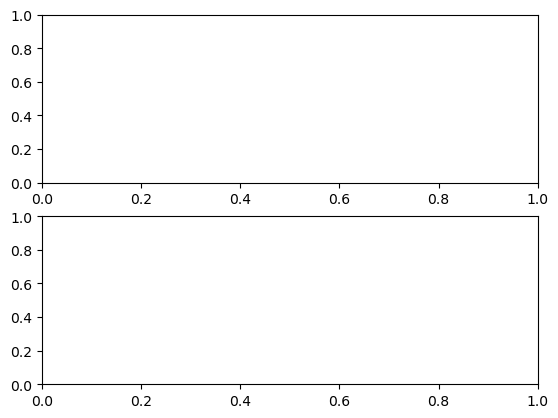

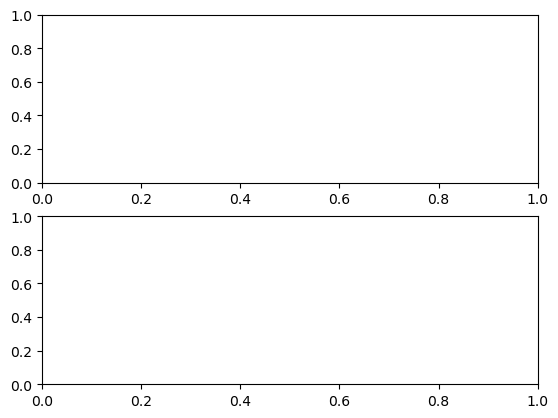

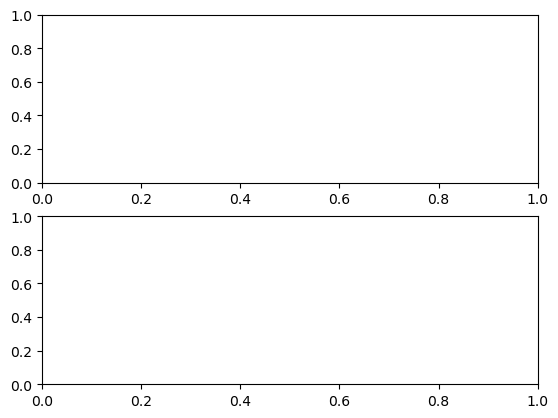

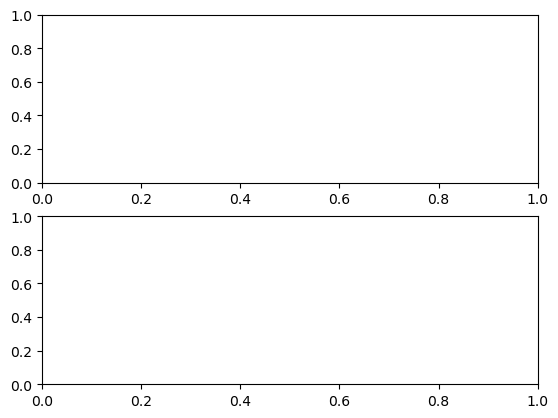

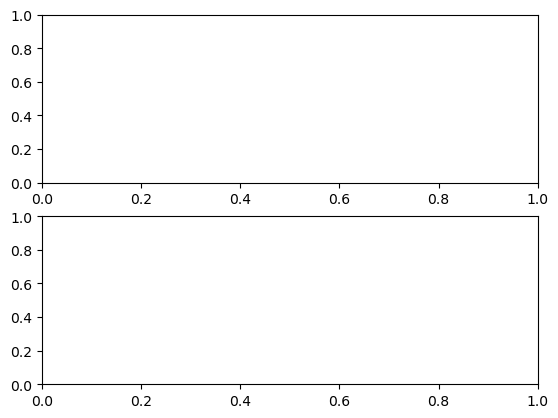

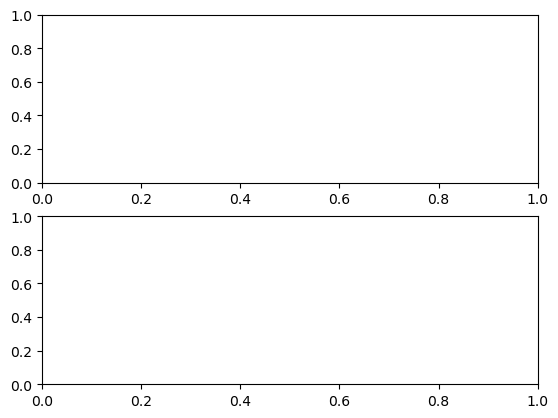

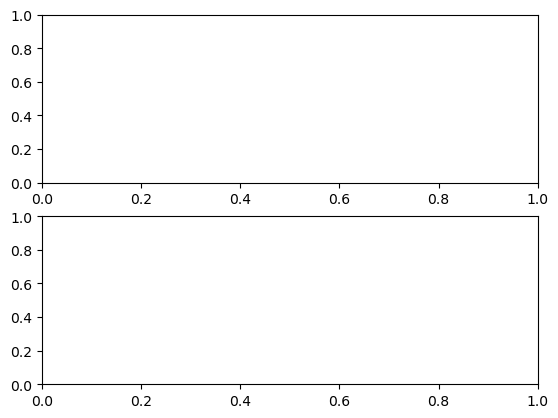

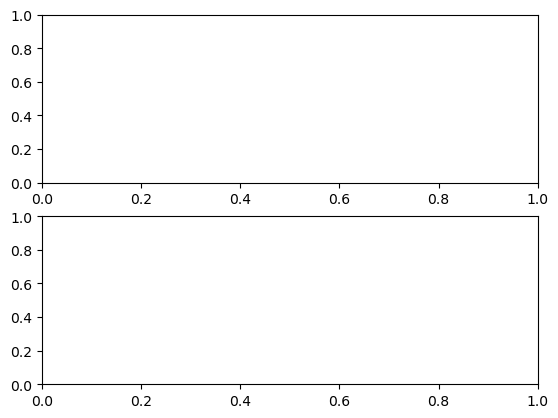

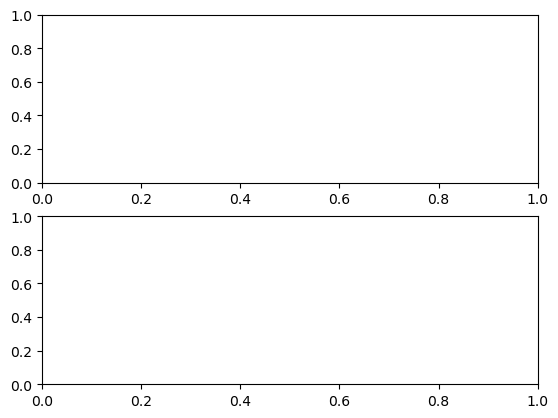

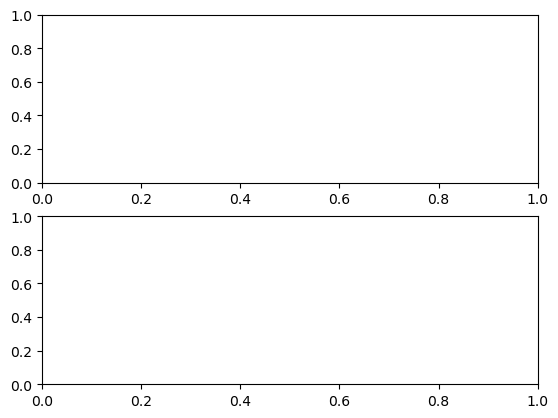

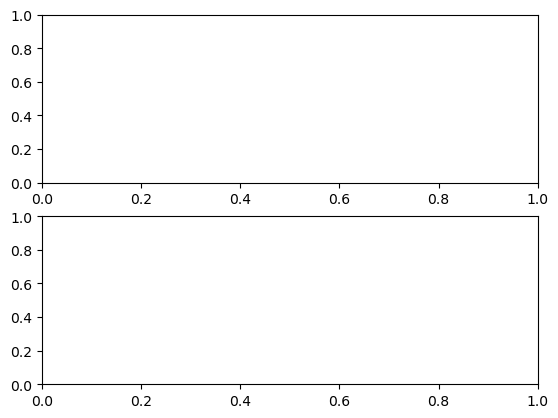

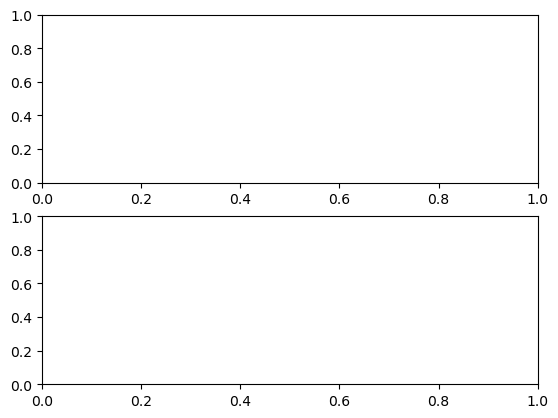

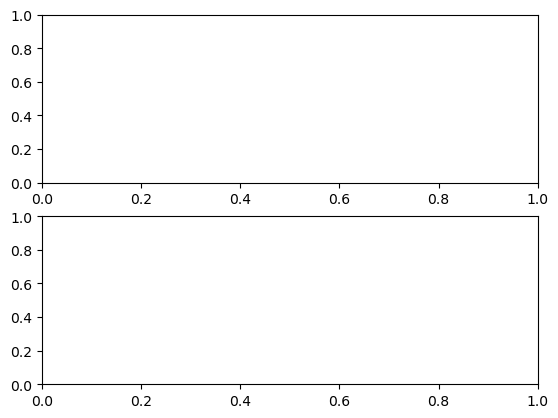

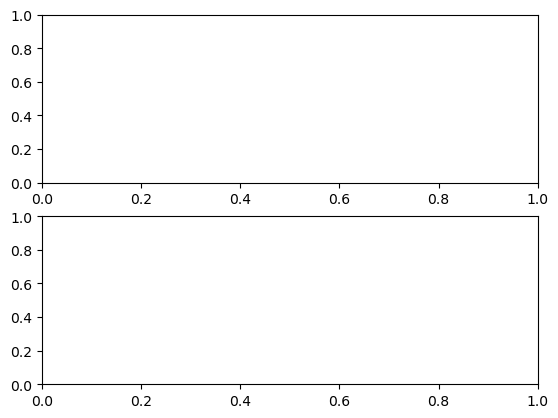

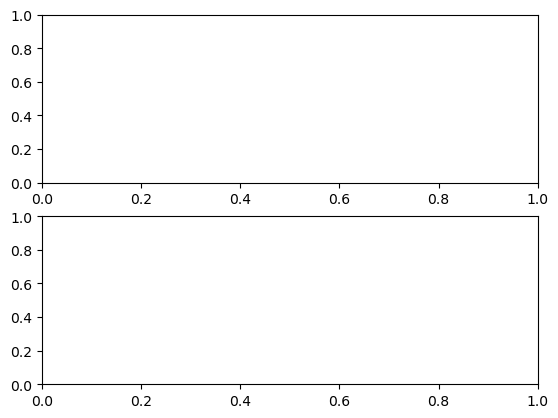

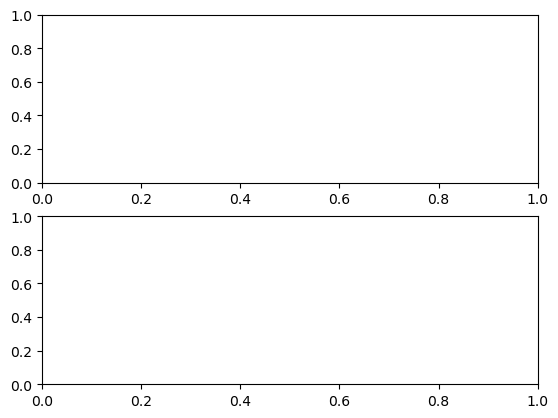

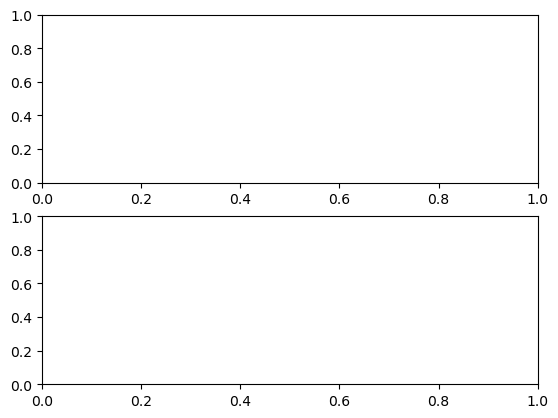

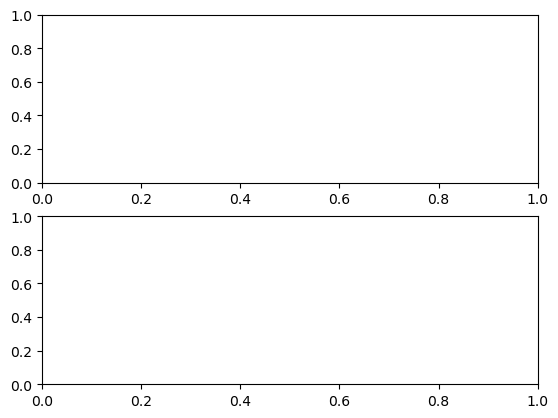

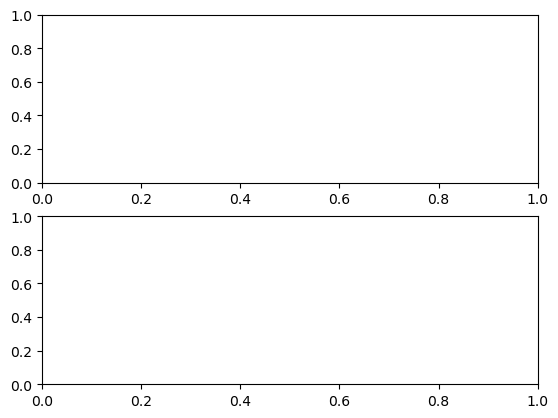

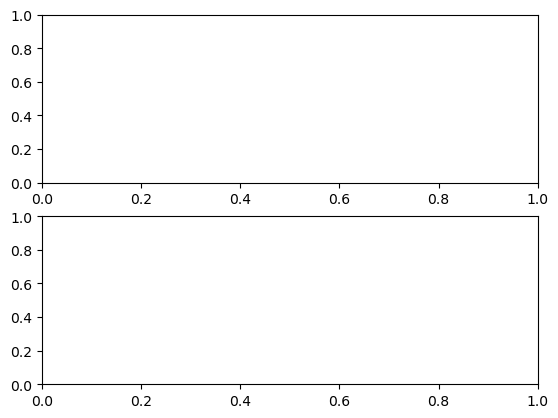

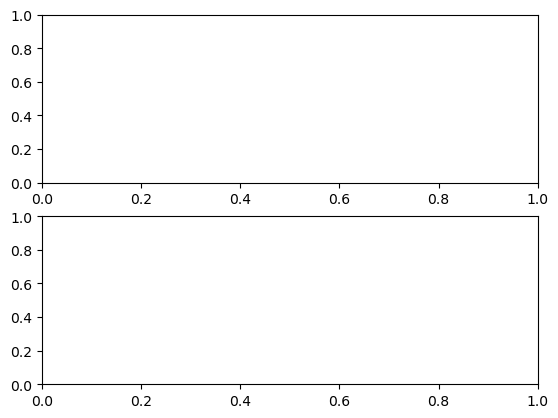

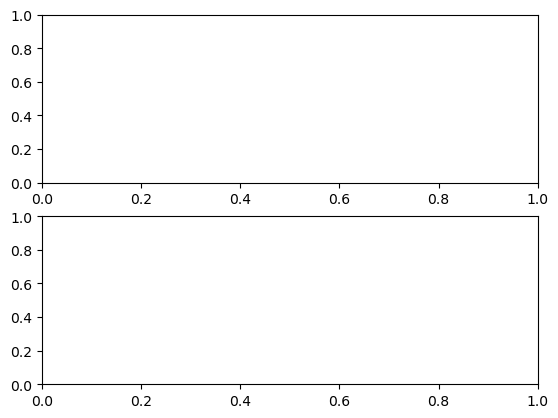

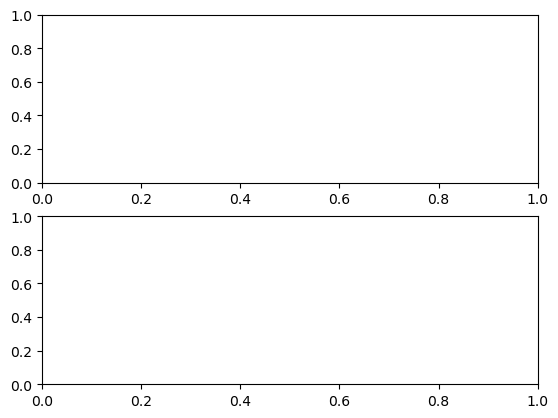

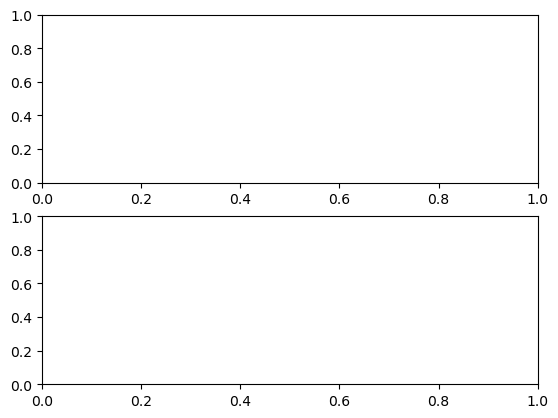

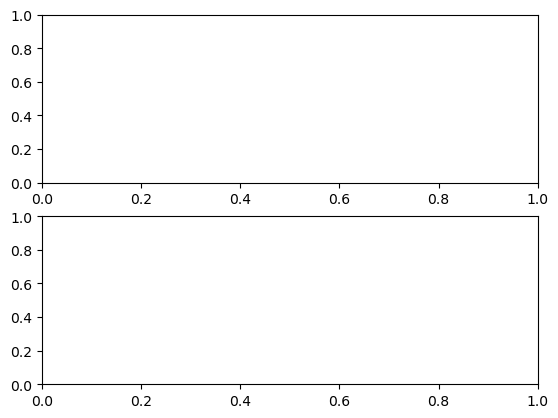

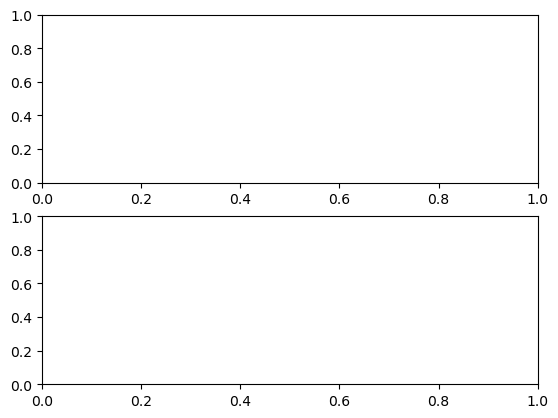

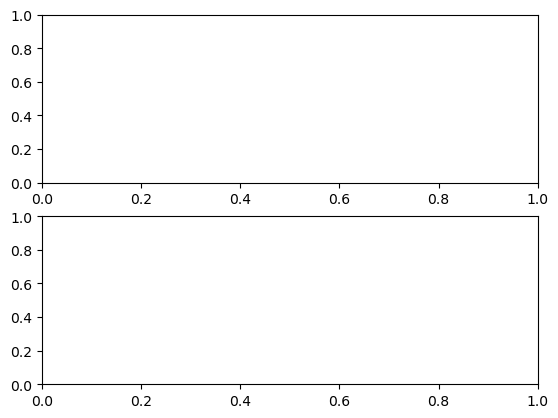

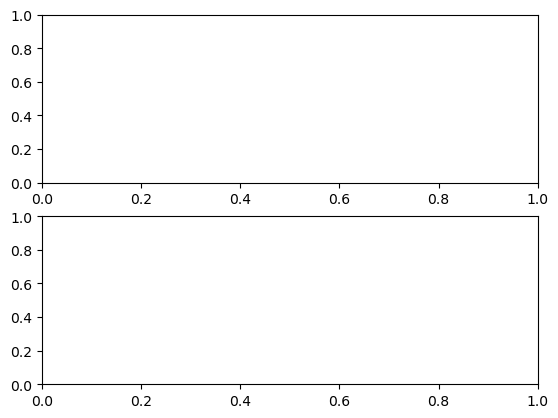

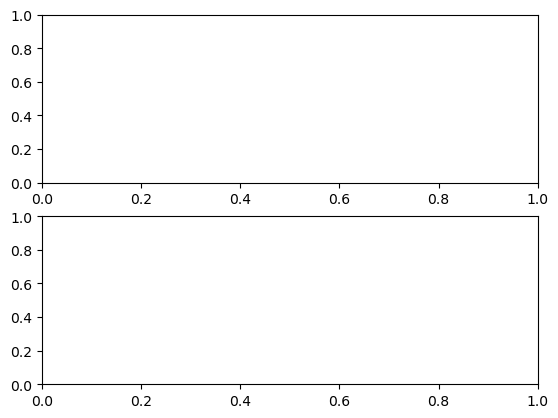

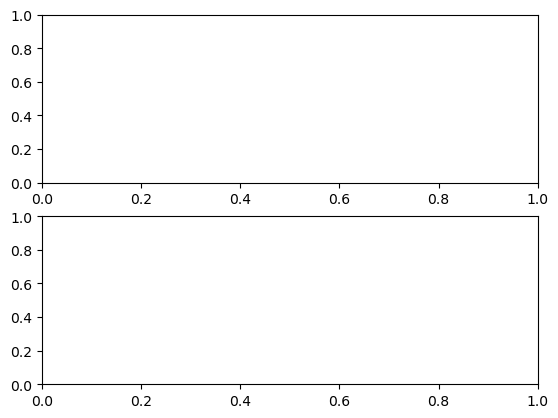

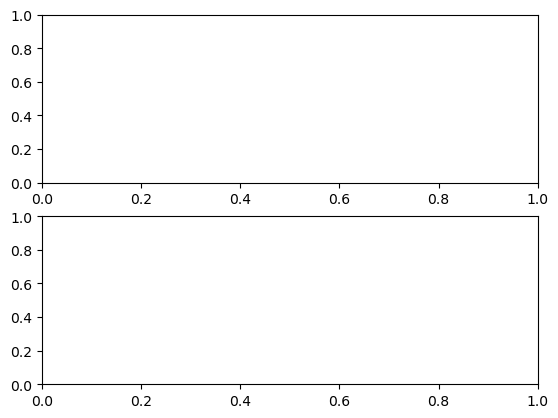

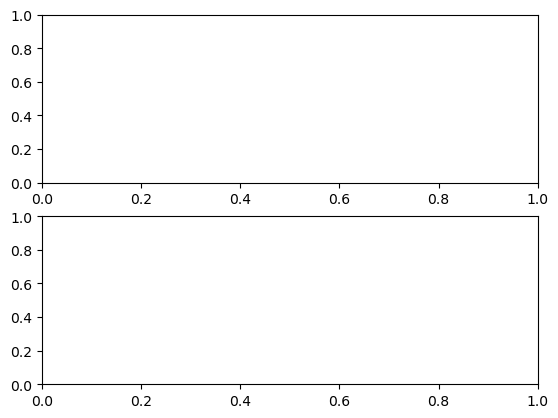

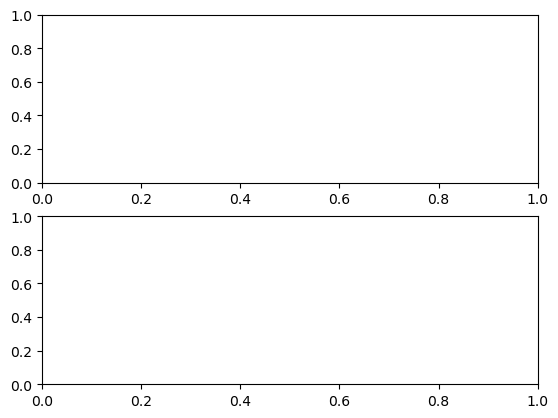

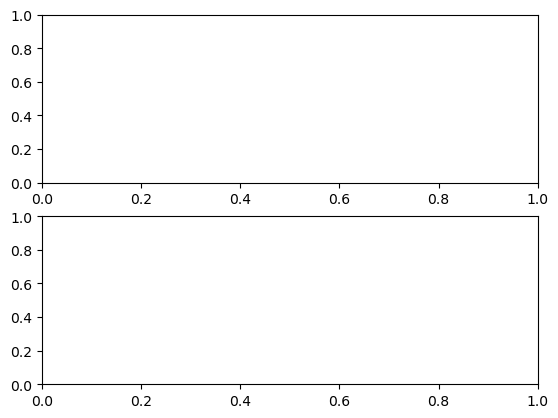

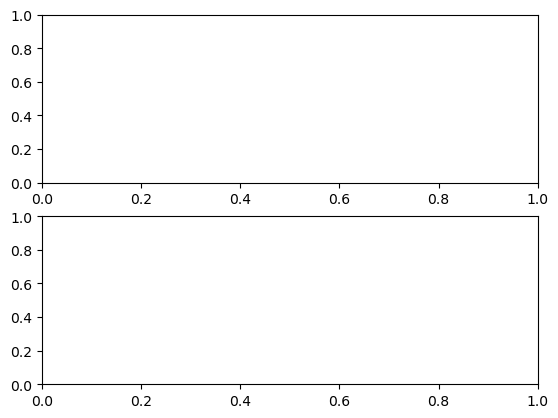

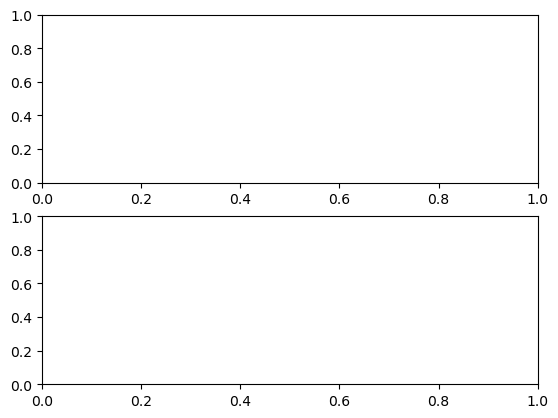

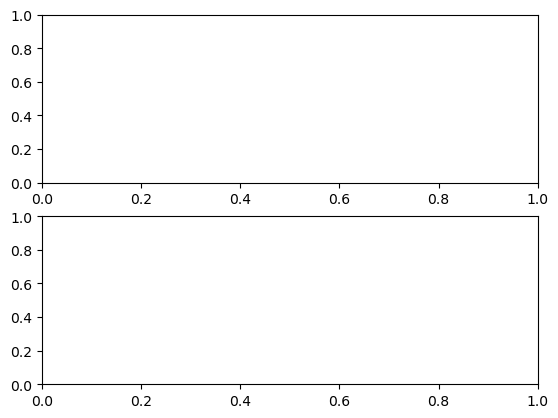

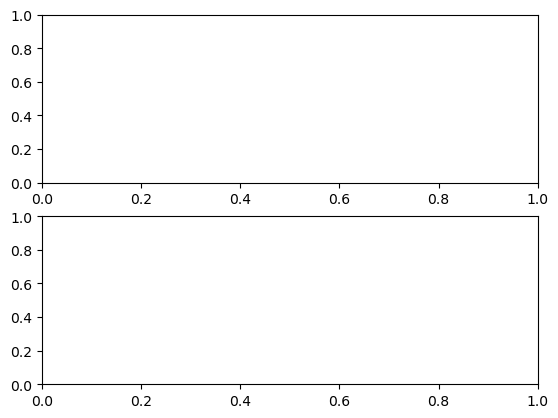

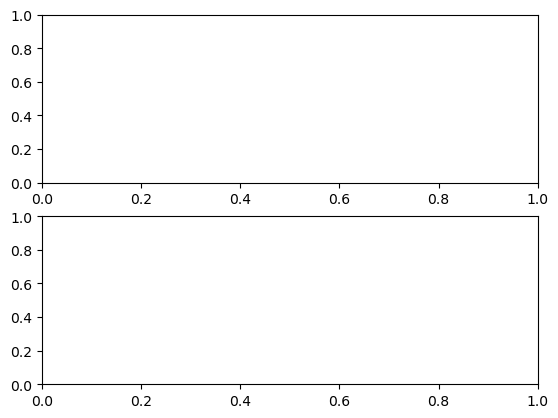

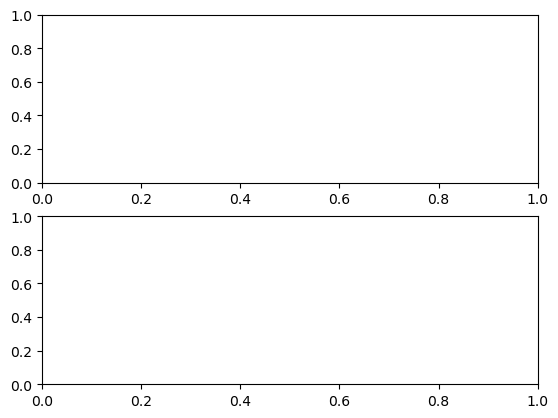

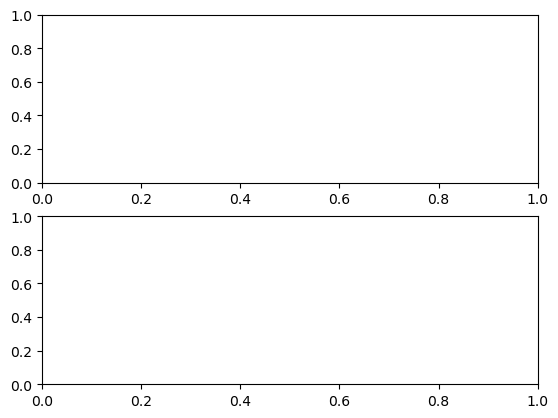

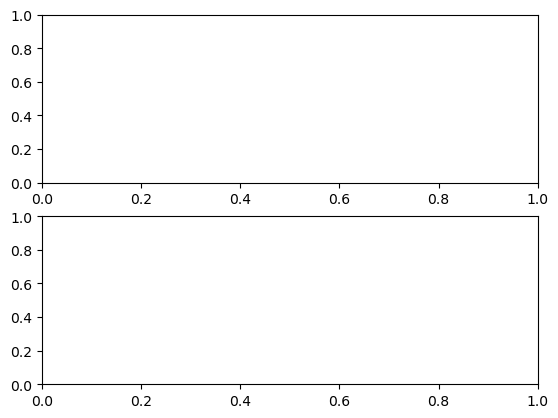

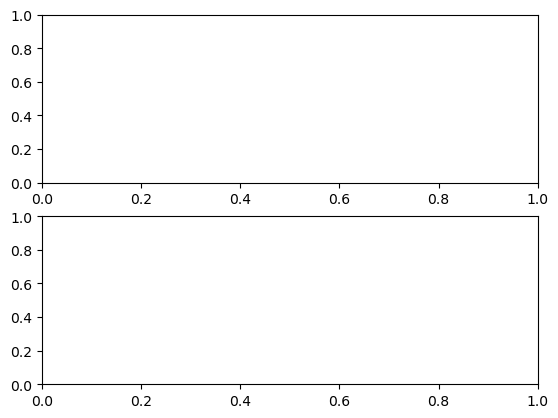

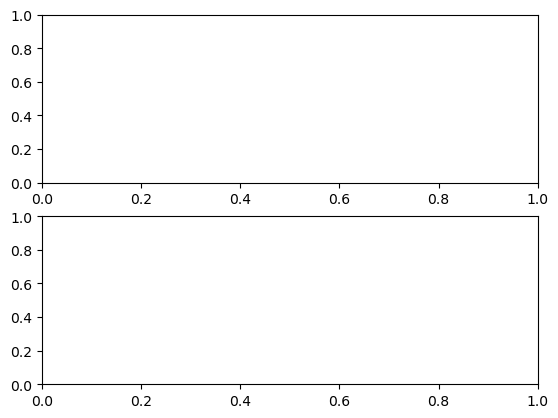

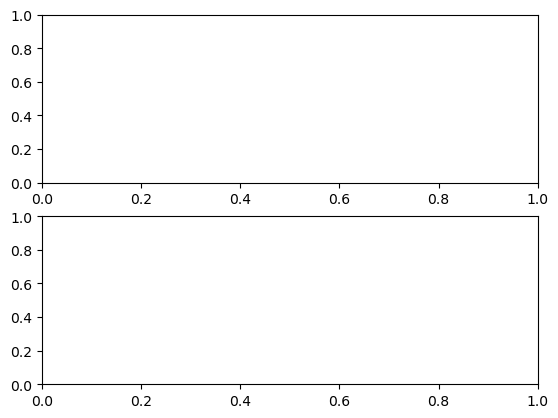

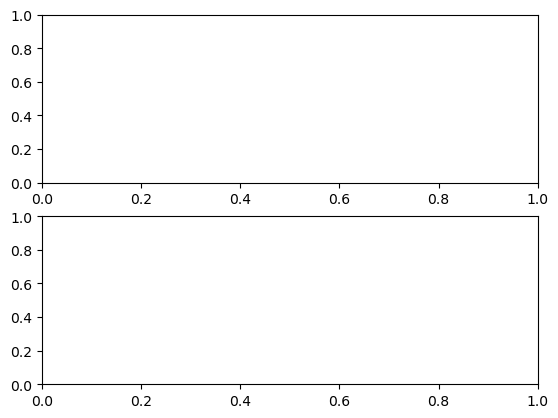

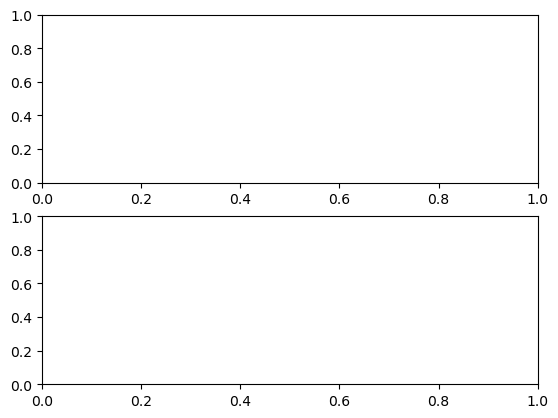

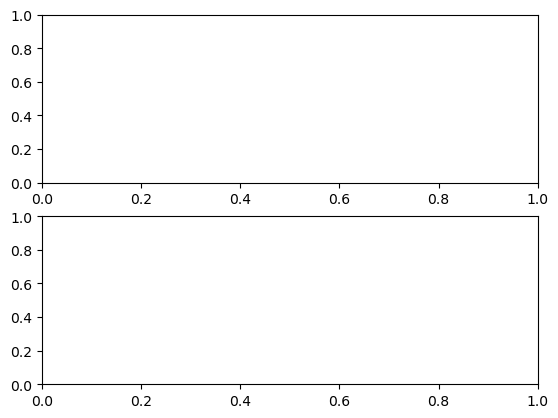

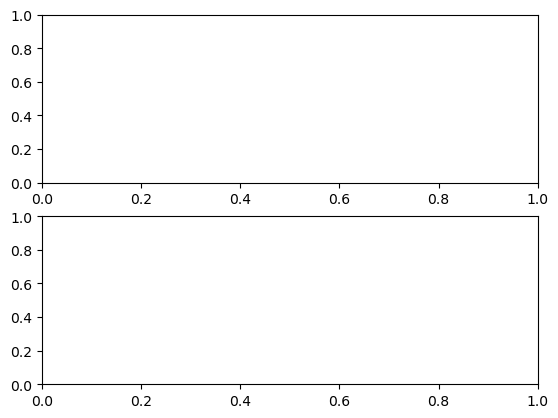

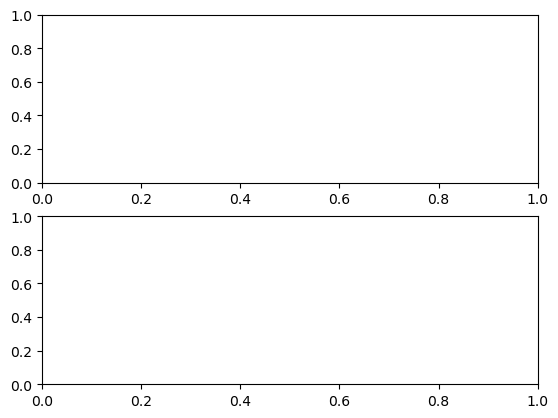

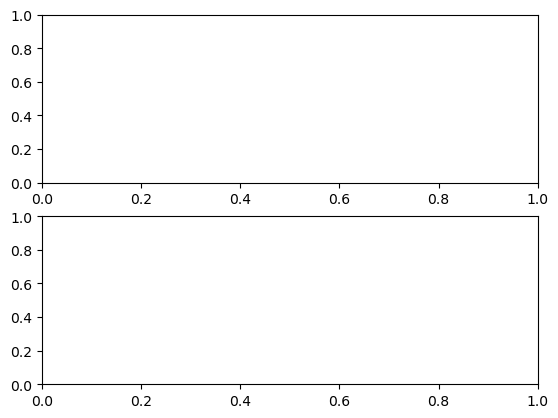

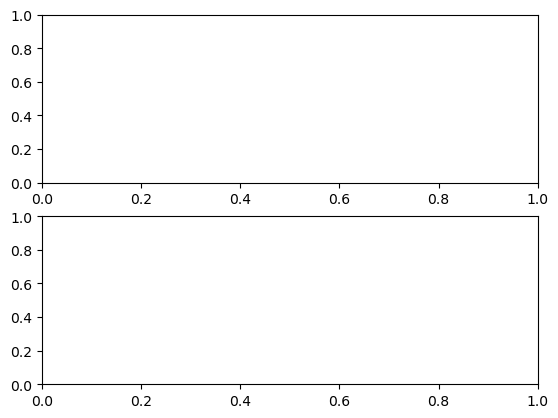

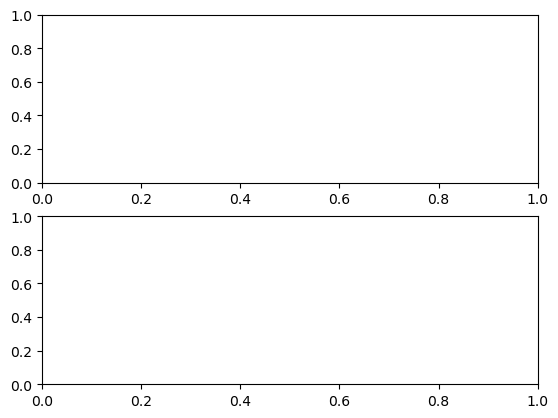

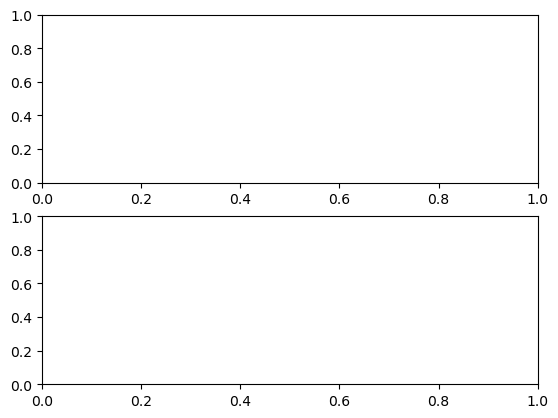

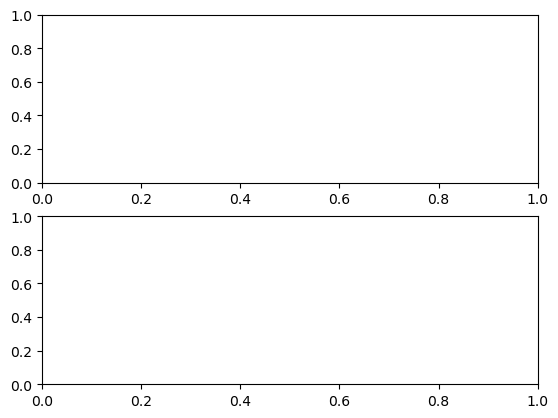

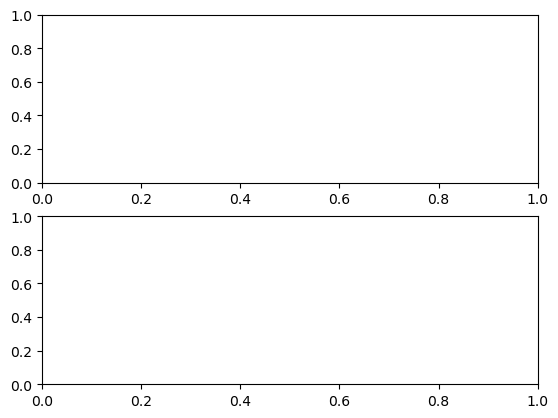

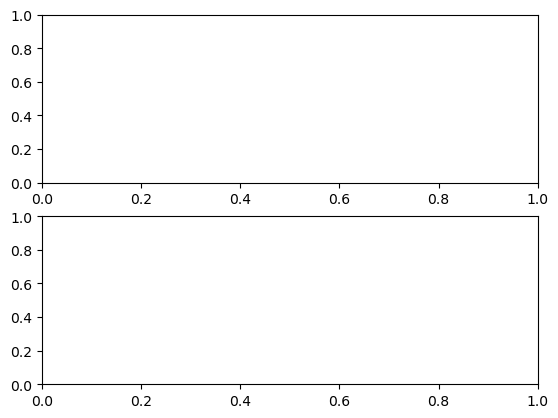

In [7]:
# loop over each pklfile
startdate = pd.to_datetime('2022-07-21')
enddate = pd.to_datetime('2022-12-02')
d = startdate
while d < enddate:
    pkloutfile = os.path.join(OUTPUTDIR, f'{d.strftime("%Y%m%d")}.pkl')

    # check if this day already processed
    if os.path.isfile(pkloutfile.replace('.pkl', '.png')):
        d = d + pd.Timedelta(hours=24)
        continue
    
    try:
        pklfile = os.path.join(INPUTDIR, f'{d.strftime("%Y%m%d")}.pkl')
        daydf = pd.read_pickle(pklfile)
    except:
        print(f'Pickle file {pklfile} for {d} does not exist')
        d = d + pd.Timedelta(hours=24)
        continue
    else:
        daydf.drop(columns=daydf.columns[daydf.columns.str.startswith('Therm')], inplace=True)
        for well in wells:
            for serial in sensors[well]:
                corrcol = f'{serial}_corrected'
                wlmcol = f'{serial}_wlm'
                hccol = f'{wlmcol}_hc'
                
                if not corrcol in daydf.columns:
                    continue

                this_transducer = LLE.get_transducer_metadata(serial, transducersDF)          
                wlmseries = LLE.psi2meters(daydf[corrcol])
                print('\ndespiking', d, well, serial)
                daydf[wlmcol] = LLE.median_despike(wlmseries, 30*100*60, threshold=1/12) # 30 minutes of data. 1 inch max departure from median in that time. # MOVEDS THIS FROM 4 LINES UP
        
                # load height correction data, which is every minute, and interpolate to 10 ms, then merge into daydf
                # save new columns serial_wldiff and serial_wlm_corrected
                print('\ncorrecting', d, well, serial)
                csvfile = os.path.join(OUTPUTDIR, f'{serial}_height_correction_feet.csv')
                if os.path.isfile(csvfile):
                    hcdf = pd.read_csv(csvfile, index_col=None)
                    hcdf['measured_datetime'] = pd.to_datetime(hcdf['measured_datetime'])
                    hcdf.set_index('measured_datetime', inplace=True)
                    hcdf = hcdf.loc[daydf['datetime'].min():daydf['datetime'].max()] 
                    hcdf = hcdf.resample('10ms').interpolate()
                    hcdf.reset_index(inplace=True)
                    newcol = f'{serial}_wlmdiff'
                    hcdf.rename(columns={'wlm_diff':newcol}, inplace=True)

                    # join
                    daydf = daydf.merge(hcdf, left_on='datetime', right_on='measured_datetime', how='inner')
                    daydf.drop(columns='measured_datetime', inplace=True)
                    daydf[hccol] = daydf[wlmcol] + daydf[newcol] 
        
        daydf.to_pickle(pkloutfile)

        # downsample for plotting
        daydf.set_index('datetime', inplace=True)
        daydf = daydf.resample('1min').median()
        daydf.reset_index(inplace=True)

        fh, axs = plt.subplots(2,1)
        for i, well in enumerate(wells):
            print('*******************')
            print(f'**** {well} Well ****')
            available_sensors = list(set(daydf.columns) & set(sensors[well])) 
            wlm_channels = [f'{chan}_wlm' for chan in available_sensors]
            if len(wlm_channels)>0:
                daydf.plot(ax=axs[i], x='datetime', y=wlm_channels, ylabel='Water Level (m, NAVD88)', xlim=[d,d+pd.Timedelta(hours=24)], title=well)
        plt.savefig(pkloutfile.replace('.pkl', '.png'))

    
    d = d + pd.Timedelta(hours=24)

